# 8c. MEZXRF GeCMOS epithelial cell pellets with standard panel by IMC analysis
## 1. Summary
This notebook quantifies channel features and generates the figures associated with the IMC breast cancer microarray scans comprising Supplementary Figure 1 in the MEZ-XRF paper.

In [1]:
import pathlib
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import hph_adata_analysis as hph_adata
import scanpy as sc
import anndata as ad

import seaborn as sns

from shutil import copyfile
from imctools.io.mcd.mcdparser import McdParser
from imctools.io.txt.txtparser import TxtParser

from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.pyplot import rc_context

from pymca_repack import unpack_pymca_h5, XrfImageMaskHDF

from skimage import filters
from skimage.transform import rescale, resize, downscale_local_mean

import high_plex_hdf as hph
import utilities

In [2]:
# Set data directory to work from 
base_dir = "C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF"
base_dir = pathlib.Path(base_dir)

# Specify the input directory where hdf files to process are located
input_dir = base_dir / 'data' / 'raw' / 'imc' / '20221215_TsH_ESRF2021Nov_cellpellet'

# Gather mcd ROIs for repackaging
imc_filepaths = list(input_dir.glob('*.txt'))
imc_filepaths = [imc_filepath for imc_filepath in imc_filepaths if 'sp-' not in imc_filepath.stem]

# Make output directory for unpacked IMC files
out_dir = base_dir / 'data' / 'analysis' / 'imc' / '8c_imc_GeCMOS_standard_cell_pellet'
out_dir.mkdir(parents=True, exist_ok=True)
print('IMC epithelial cell pellet analysis will be output to: \n\t', out_dir) 

# Import csv of manually determined overlap coordinates between XRF and IMC
df_xrf_imc_overlap = pd.read_csv(base_dir / 'data' / 'raw' / 'imc_xrf_overlap_coords.csv')

# Import periodic table csv
df_periodic_table = pd.read_csv(base_dir / 'data' / 'raw' / 'xrf' / 'Periodic Table of Elements.csv')

imc_filepaths

IMC epithelial cell pellet analysis will be output to: 
	 C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\imc\8c_imc_GeCMOS_standard_cell_pellet


[WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/raw/imc/20221215_TsH_ESRF2021Nov_cellpellet/20221215_TsH_ESRF2021Nov_cellpellet_st-cp_a431_8.txt'),
 WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/raw/imc/20221215_TsH_ESRF2021Nov_cellpellet/20221215_TsH_ESRF2021Nov_cellpellet_st-cp_mcf10a_5.txt'),
 WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/raw/imc/20221215_TsH_ESRF2021Nov_cellpellet/20221215_TsH_ESRF2021Nov_cellpellet_st-cp_skbr3_7.txt'),
 WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/raw/imc/20221215_TsH_ESRF2021Nov_cellpellet/20221215_TsH_ESRF2021Nov_cellpellet_st-cp_zr751_6.txt')]

In [3]:
 # Collect experiment antibody panel for additional channel information
panel_path = base_dir / 'data' / 'raw' / 'antibody_panels' / 'saber_cell_pellet_standard_panel.csv'

df_panel = pd.read_csv(panel_path)
df_panel

ab_tag  tag_isotope xrf_emission                 target shortname ab_clone  \
0     Y89           89         Y_Ka     phospho histone h3      pHH3    HTA28   
1   Rh103          103        Rh_Ka                    DNA       DNA       Rh   
2    I127          127         I_Ka                    IdU       IdU      IdU   
3   La139          139        La_Ka  Progesterone Receptor        PR      NaN   
4   Pr141          141        Pr_Ka                  Ki-67     Ki-67      B56   
5   Nd145          145        Nd_Ka        c-erbB-2 - Her2      HER2    D8F12   
6   Tb159          159        Tb_Ka          Cytokeratin 5       CK5  EP1601Y   
7   Dy161          161        Dy_Ka          Cytokeratin 7       CK7   RCK105   
8   Ho165          165        Ho_Ka             Histone H3       HH3     D1H2   
9   Tm169          169        Tm_Ka               Vimentin       Vim  EPR3776   
10  Lu175          175        Lu_Ka     Keratin Epithelial     panCK      AE3   
11  Ir191          191        Ir_L3                    DNA       DNA      NaN   
12  Ir193          193        Ir_L3                    DNA       DNA      NaN   

    stock_conc_ug_per_ml  use_conc_ug_per_mL  nuclear_segment  cell_segment  
0                    NaN                 NaN              NaN           NaN  
1                    NaN                 NaN              NaN           NaN  
2                    NaN                 NaN              NaN           NaN  
3                    NaN                 NaN              NaN           NaN  
4                    NaN                 NaN              NaN           NaN  
5                    NaN                 NaN              NaN           NaN  
6                    NaN                 NaN              NaN           1.0  
7                    NaN                 NaN              NaN           NaN  
8                    NaN                 NaN              1.0           NaN  
9                    NaN                 NaN              NaN           1.0  
10                   NaN                 NaN              NaN           1.0  
11                   NaN                 NaN              1.0           NaN  
12                   NaN                 NaN              1.0           NaN

In [4]:
hdf_substitute = {
    'mcf10a':'MCF10a',
    'a431':'A431',
    'zr751':'ZR-75-1',
    'skbr3':'SKBR3',
}

def imc_txt_to_hph(imc_filepath, df_panel, sample_name_ref, out_dir=None):
    acquisition_info = [
        'mcd_filepath',   
        'mcd_filename',   
        'acq_id',
        'acq_id_description',
        'step_um',
        'x_dim', 
        'y_dim',
    ]

    df_standard_measurements = pd.DataFrame(columns=acquisition_info)
    roi_dict = dict.fromkeys(acquisition_info)

    with TxtParser(imc_filepath) as parser:
        # Get acquisition
        acq_data = parser.get_acquisition_data()

        ## Collect key metadata for hdf packing
        roi_dict['mcd_filepath'] = str(imc_filepath)
        roi_dict['mcd_filename'] = str(imc_filepath.name)

        roi_dict['acq_id'] = acq_data.acquisition.id 
        roi_dict['acq_id_description'] = acq_data.acquisition.description

    #     assert(acq_data.acquisition.ablation_distance_between_shots_x == acq_data.acquisition.ablation_distance_between_shots_y)
        roi_dict['step_um'] = 0.5 # this may be accessible in mcd route, but not txt route, so defaults to 0.5
        roi_dict['x_dim'] = acq_data.acquisition.max_x
        roi_dict['y_dim'] = acq_data.acquisition.max_y

        ## Collect key channel information
        df_channels = pd.DataFrame(
            {
                'channel_labels':acq_data.channel_labels,
                'channel_masses':acq_data.channel_masses,
                'channel_names':acq_data.channel_names,
            }
        )

        ## Add panel information to channel information
        # Convert for panel merge
        df_channels['channel_masses'] = (pd.to_numeric(df_channels['channel_masses']))  

        # Panel merge
        df_channel_metadata = pd.merge(
            df_channels, 
            df_panel, 
            left_on='channel_masses', 
            right_on='tag_isotope', 
            how='left'
        ) 

        # Log channels loaded with a marker
        df_channel_metadata['loaded_channel'] = df_channel_metadata['channel_masses'].isin(df_panel['tag_isotope'])

        # Make longname for IMC samples
        df_channel_metadata['shortname'] = df_channel_metadata['shortname'].astype(str)
        df_channel_metadata['longname_imc'] = (
            df_channel_metadata[['channel_names', 'shortname']].agg(' | '.join, axis=1)
            )  
        
        # Add plot channel name
        df_channel_metadata['plot_channel'] = df_channel_metadata['longname_imc']

        ## Get image stack    
        img_stack = np.moveaxis(
            acq_data.image_data, 
            source=[0, 1, 2], 
            destination=[2, 1, 0],
        )
        img_stack = np.flip(img_stack, axis=1)[:250,:250,:]
        
        print(img_stack.shape)

        # Package to hph object
        roi_hph = hph.HighPlexHdf(
            images = {'raw':img_stack},
            channel_metadata = df_channel_metadata,
            masks = {},
            sample_metadata=roi_dict
        )
        
        roi_hph.sample_metadata['sample_name_ref'] = sample_name_ref
        roi_hph.sample_metadata['AB_panel'] = panel_path.stem
        
        if isinstance(out_dir, pathlib.Path):
            if out_dir.is_dir():
                output_fpath = out_dir / f"{sample_name_ref}.h5"            
                roi_hph.export_hdf(
                    output_fpath = output_fpath
                )
  
    return roi_hph, df_channel_metadata

for imc_filepath in imc_filepaths[:]:
    sample_name = hdf_substitute[imc_filepath.stem.split('_')[-2]]
    roi_hph, df_channel_metadata = imc_txt_to_hph(imc_filepath, df_panel=df_panel, sample_name_ref=sample_name, out_dir=out_dir)

# df_channel_metadata
roi_hph.channel_metadata


(250, 250, 27)
(250, 250, 27)
(250, 250, 27)
(250, 250, 27)


channel_labels  channel_masses channel_names ab_tag  tag_isotope  \
0       89Y(Y89Di)              89           Y89    Y89         89.0   
1   103Rh(Rh103Di)             103         Rh103  Rh103        103.0   
2   115In(In115Di)             115         In115    NaN          NaN   
3     127I(I127Di)             127          I127   I127        127.0   
4   139La(La139Di)             139         La139  La139        139.0   
5   140Ce(Ce140Di)             140         Ce140    NaN          NaN   
6   141Pr(Pr141Di)             141         Pr141  Pr141        141.0   
7   144Nd(Nd144Di)             144         Nd144    NaN          NaN   
8   145Nd(Nd145Di)             145         Nd145  Nd145        145.0   
9   148Nd(Nd148Di)             148         Nd148    NaN          NaN   
10  151Eu(Eu151Di)             151         Eu151    NaN          NaN   
11  152Sm(Sm152Di)             152         Sm152    NaN          NaN   
12  153Eu(Eu153Di)             153         Eu153    NaN          NaN   
13  154Sm(Sm154Di)             154         Sm154    NaN          NaN   
14  155Gd(Gd155Di)             155         Gd155    NaN          NaN   
15  156Gd(Gd156Di)             156         Gd156    NaN          NaN   
16  158Gd(Gd158Di)             158         Gd158    NaN          NaN   
17  159Tb(Tb159Di)             159         Tb159  Tb159        159.0   
18  161Dy(Dy161Di)             161         Dy161  Dy161        161.0   
19  165Ho(Ho165Di)             165         Ho165  Ho165        165.0   
20  166Er(Er166Di)             166         Er166    NaN          NaN   
21  169Tm(Tm169Di)             169         Tm169  Tm169        169.0   
22  171Yb(Yb171Di)             171         Yb171    NaN          NaN   
23  172Yb(Yb172Di)             172         Yb172    NaN          NaN   
24  175Lu(Lu175Di)             175         Lu175  Lu175        175.0   
25  191Ir(Ir191Di)             191         Ir191  Ir191        191.0   
26  193Ir(Ir193Di)             193         Ir193  Ir193        193.0   

   xrf_emission                 target shortname ab_clone  \
0          Y_Ka     phospho histone h3      pHH3    HTA28   
1         Rh_Ka                    DNA       DNA       Rh   
2           NaN                    NaN       nan      NaN   
3          I_Ka                    IdU       IdU      IdU   
4         La_Ka  Progesterone Receptor        PR      NaN   
5           NaN                    NaN       nan      NaN   
6         Pr_Ka                  Ki-67     Ki-67      B56   
7           NaN                    NaN       nan      NaN   
8         Nd_Ka        c-erbB-2 - Her2      HER2    D8F12   
9           NaN                    NaN       nan      NaN   
10          NaN                    NaN       nan      NaN   
11          NaN                    NaN       nan      NaN   
12          NaN                    NaN       nan      NaN   
13          NaN                    NaN       nan      NaN   
14          NaN                    NaN       nan      NaN   
15          NaN                    NaN       nan      NaN   
16          NaN                    NaN       nan      NaN   
17        Tb_Ka          Cytokeratin 5       CK5  EP1601Y   
18        Dy_Ka          Cytokeratin 7       CK7   RCK105   
19        Ho_Ka             Histone H3       HH3     D1H2   
20          NaN                    NaN       nan      NaN   
21        Tm_Ka               Vimentin       Vim  EPR3776   
22          NaN                    NaN       nan      NaN   
23          NaN                    NaN       nan      NaN   
24        Lu_Ka     Keratin Epithelial     panCK      AE3   
25        Ir_L3                    DNA       DNA      NaN   
26        Ir_L3                    DNA       DNA      NaN   

    stock_conc_ug_per_ml  use_conc_ug_per_mL  nuclear_segment  cell_segment  \
0                    NaN                 NaN              NaN           NaN   
1                    NaN                 NaN              NaN           NaN   
2                    NaN                 

## Segment IMC data


 Segmented hdf files will be output to: 
	 C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\imc\8c_imc_GeCMOS_standard_cell_pellet\segmented
pixel size:  0.5


C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


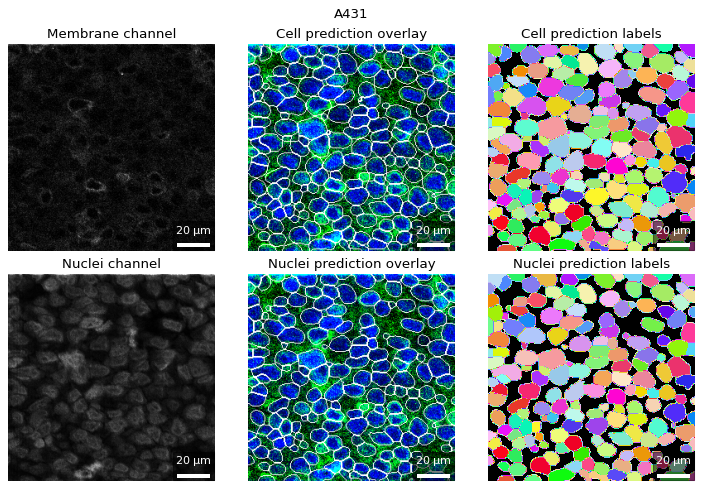

matched_cell_mask 173
matched_nuclei_mask 173
matched_non_nuclei_mask 173


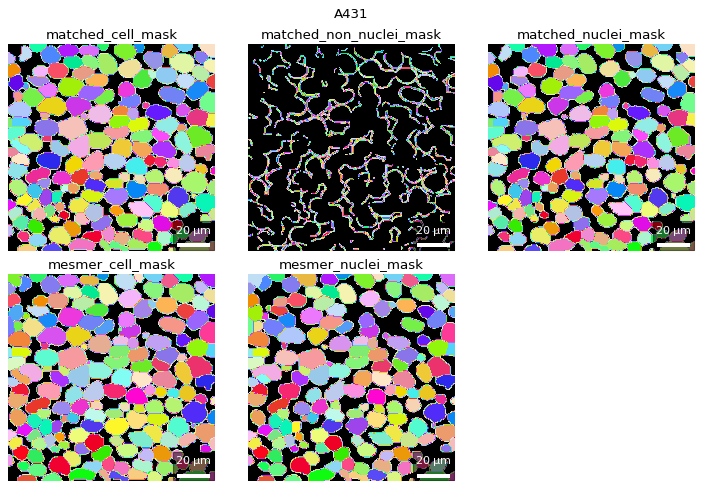

pixel size:  0.5


C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


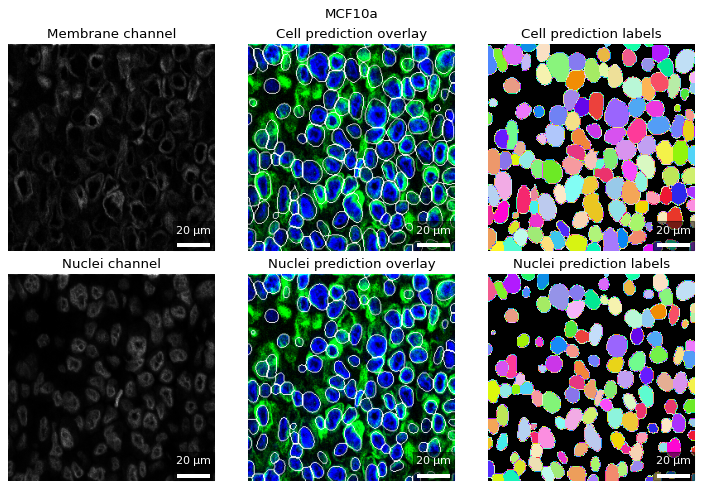

matched_cell_mask 122
matched_nuclei_mask 122
matched_non_nuclei_mask 122


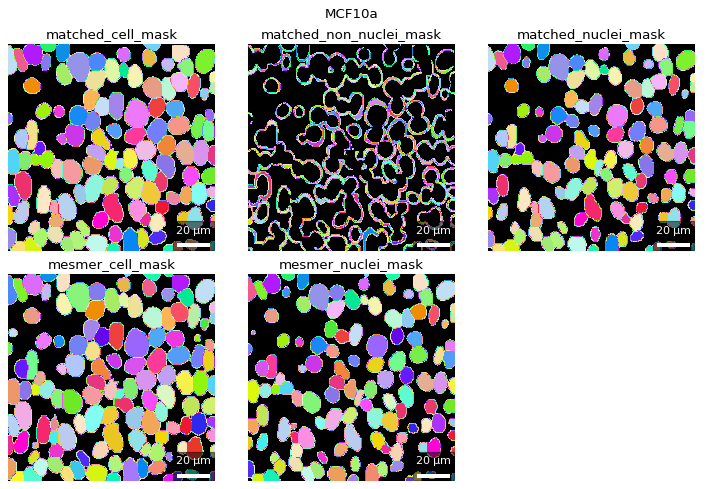

pixel size:  0.5


C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


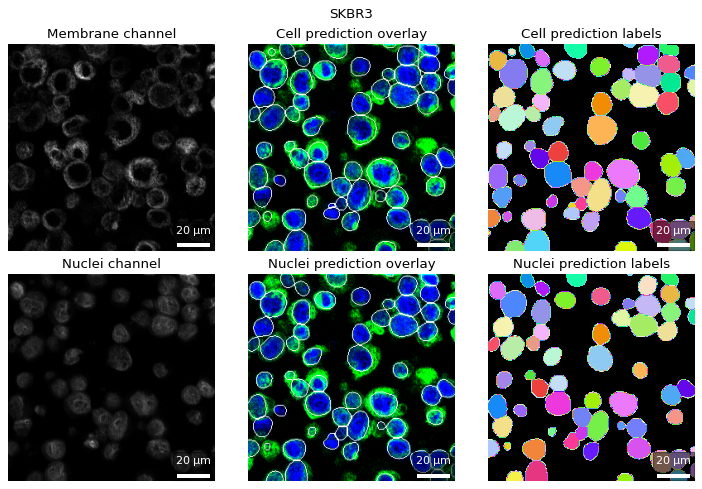

matched_cell_mask 62
matched_nuclei_mask 62
matched_non_nuclei_mask 62


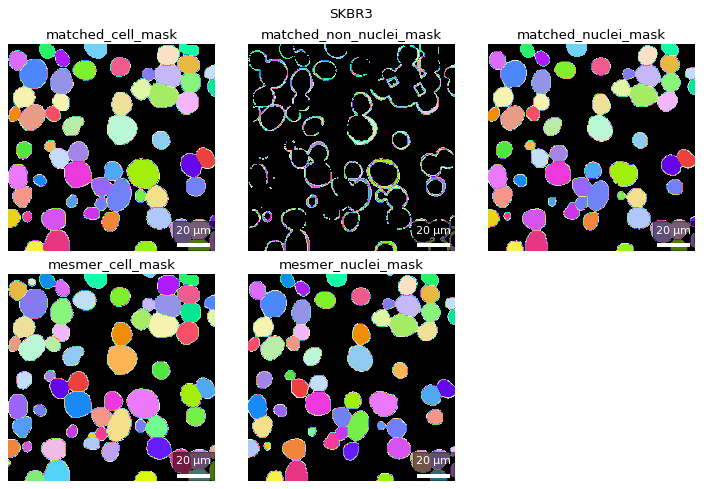

pixel size:  0.5


C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


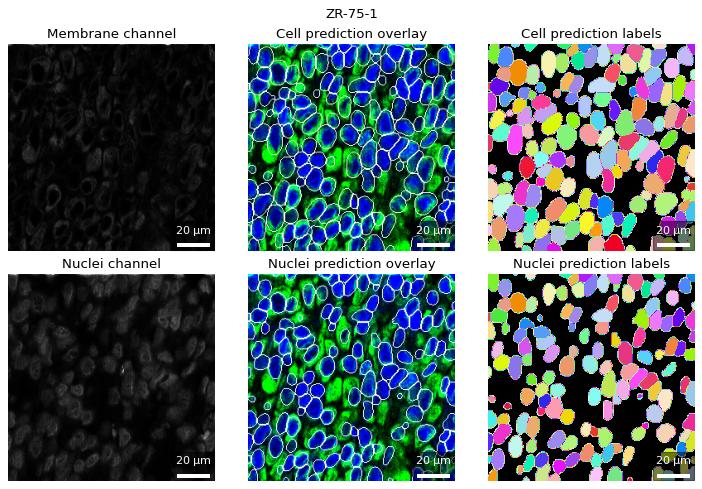

matched_cell_mask 136
matched_nuclei_mask 136
matched_non_nuclei_mask 136


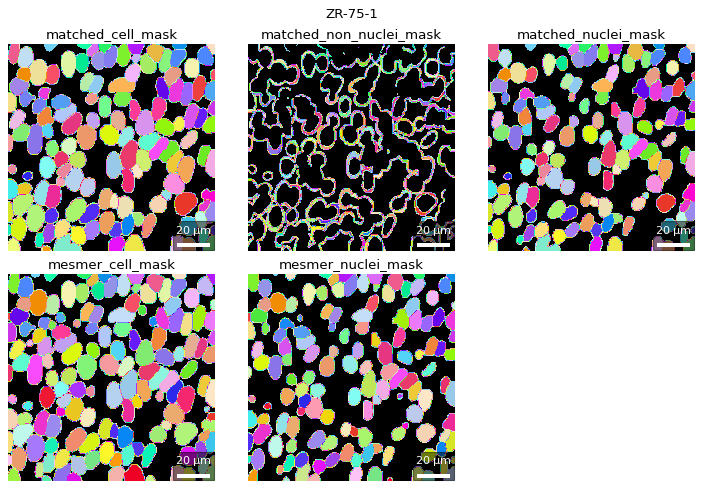

In [5]:
# Make output directory segmented images
out_sub_dir = out_dir / 'segmented'
out_sub_dir.mkdir(parents=True, exist_ok=True)
print('\n Segmented hdf files will be output to: \n\t',out_sub_dir) 

hdfs_to_segment = list(out_dir.glob('*.h5'))
hdfs_to_segment = [hdf_to_segment for hdf_to_segment in hdfs_to_segment if 'MCF7' not in hdf_to_segment.stem]

for hdf_fpath in hdfs_to_segment[:]:    
    hdf_segment = hph.hdf_to_HighPlex_Hdf(hdf_fpath=hdf_fpath)
    
    # Run segmentation
    # Parameters explained here https://github.com/vanvalenlab/deepcell-tf/blob/master/notebooks/applications/Mesmer-Application.ipynb
    hdf_segment.mesmer_segment()
    hdf_segment.mesmer_output_plot(out_dir = out_sub_dir)
    hdf_segment.cell_nuclei_match()
    hdf_segment.segmented_masks_plot(out_dir = out_sub_dir)
    hdf_segment.export_masks_to_source_hdf()
    
for source_fpath in hdfs_to_segment:
    output_fpath = out_sub_dir / f'{source_fpath.stem}_segmented.h5'
    source = copyfile(source_fpath, output_fpath)         

## Single cell analysis measurements of IMC data
Measure intensities for all cell masks

In [5]:
# hdf_analysis_filepaths = [hdf_analysis_path for hdf_analysis_path in hdfs_to_segment if 'MCF7' not in hdf_analysis_path.stem]
# The order determines how loaded into hdf, and order of later output images
hdf_analysis_filepaths = [
    pathlib.Path(r'C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8c_imc_GeCMOS_standard_cell_pellet/MCF10a.h5'),
    pathlib.Path(r'C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8c_imc_GeCMOS_standard_cell_pellet/A431.h5'),
    pathlib.Path(r'C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8c_imc_GeCMOS_standard_cell_pellet/ZR-75-1.h5'),
    pathlib.Path(r'C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8c_imc_GeCMOS_standard_cell_pellet/SKBR3.h5'),]

hdf_analysis_filepaths

[WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8c_imc_GeCMOS_standard_cell_pellet/MCF10a.h5'),
 WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8c_imc_GeCMOS_standard_cell_pellet/A431.h5'),
 WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8c_imc_GeCMOS_standard_cell_pellet/ZR-75-1.h5'),
 WindowsPath('C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/analysis/imc/8c_imc_GeCMOS_standard_cell_pellet/SKBR3.h5')]

In [6]:
hph.hdf_to_HighPlex_Hdf(hdf_analysis_filepaths[0]).images['raw'].shape
hph.hdf_to_HighPlex_Hdf(hdf_analysis_filepaths[1]).channel_metadata#.drop([0,7])#.shape

channel_labels  channel_masses channel_names ab_tag  tag_isotope  \
0       89Y(Y89Di)              89           Y89    Y89         89.0   
1   103Rh(Rh103Di)             103         Rh103  Rh103        103.0   
2   115In(In115Di)             115         In115    NaN          NaN   
3     127I(I127Di)             127          I127   I127        127.0   
4   139La(La139Di)             139         La139  La139        139.0   
5   140Ce(Ce140Di)             140         Ce140    NaN          NaN   
6   141Pr(Pr141Di)             141         Pr141  Pr141        141.0   
7   144Nd(Nd144Di)             144         Nd144    NaN          NaN   
8   145Nd(Nd145Di)             145         Nd145  Nd145        145.0   
9   148Nd(Nd148Di)             148         Nd148    NaN          NaN   
10  151Eu(Eu151Di)             151         Eu151    NaN          NaN   
11  152Sm(Sm152Di)             152         Sm152    NaN          NaN   
12  153Eu(Eu153Di)             153         Eu153    NaN          NaN   
13  154Sm(Sm154Di)             154         Sm154    NaN          NaN   
14  155Gd(Gd155Di)             155         Gd155    NaN          NaN   
15  156Gd(Gd156Di)             156         Gd156    NaN          NaN   
16  158Gd(Gd158Di)             158         Gd158    NaN          NaN   
17  159Tb(Tb159Di)             159         Tb159  Tb159        159.0   
18  161Dy(Dy161Di)             161         Dy161  Dy161        161.0   
19  165Ho(Ho165Di)             165         Ho165  Ho165        165.0   
20  166Er(Er166Di)             166         Er166    NaN          NaN   
21  169Tm(Tm169Di)             169         Tm169  Tm169        169.0   
22  171Yb(Yb171Di)             171         Yb171    NaN          NaN   
23  172Yb(Yb172Di)             172         Yb172    NaN          NaN   
24  175Lu(Lu175Di)             175         Lu175  Lu175        175.0   
25  191Ir(Ir191Di)             191         Ir191  Ir191        191.0   
26  193Ir(Ir193Di)             193         Ir193  Ir193        193.0   

   xrf_emission                 target shortname ab_clone  \
0          Y_Ka     phospho histone h3      pHH3    HTA28   
1         Rh_Ka                    DNA       DNA       Rh   
2           NaN                    NaN       nan      NaN   
3          I_Ka                    IdU       IdU      IdU   
4         La_Ka  Progesterone Receptor        PR      NaN   
5           NaN                    NaN       nan      NaN   
6         Pr_Ka                  Ki-67     Ki-67      B56   
7           NaN                    NaN       nan      NaN   
8         Nd_Ka        c-erbB-2 - Her2      HER2    D8F12   
9           NaN                    NaN       nan      NaN   
10          NaN                    NaN       nan      NaN   
11          NaN                    NaN       nan      NaN   
12          NaN                    NaN       nan      NaN   
13          NaN                    NaN       nan      NaN   
14          NaN                    NaN       nan      NaN   
15          NaN                    NaN       nan      NaN   
16          NaN                    NaN       nan      NaN   
17        Tb_Ka          Cytokeratin 5       CK5  EP1601Y   
18        Dy_Ka          Cytokeratin 7       CK7   RCK105   
19        Ho_Ka             Histone H3       HH3     D1H2   
20          NaN                    NaN       nan      NaN   
21        Tm_Ka               Vimentin       Vim  EPR3776   
22          NaN                    NaN       nan      NaN   
23          NaN                    NaN       nan      NaN   
24        Lu_Ka     Keratin Epithelial     panCK      AE3   
25        Ir_L3                    DNA       DNA      NaN   
26        Ir_L3                    DNA       DNA      NaN   

    stock_conc_ug_per_ml  use_conc_ug_per_mL  nuclear_segment  cell_segment  \
0                    NaN                 NaN              NaN           NaN   
1                    NaN                 NaN              NaN           NaN   
2                    NaN                 

In [7]:
# All cell mask
image_n = 'raw'
mask_n = 'mesmer_cell_mask'
adata = hph.multiple_hph_to_adata(
    hdf_filepaths = hdf_analysis_filepaths, 
    image_n = image_n,
    mask_n = mask_n
)
# Correct variable names
isotopes = [i[0] for i in adata.var.index.str.split(' ', expand=True)]
adata.var['ab_tag'] = isotopes
adata.var['ab_tag'] = adata.var['ab_tag'].astype(str)
adata.var['longname'] = adata.var.index
adata.var = adata.var.merge(df_panel, on='ab_tag', how='left', suffixes=('', '_y'))
adata.var.drop(adata.var.filter(regex='_y$').columns, axis=1, inplace=True)
adata.write(out_dir.joinpath(f'IMCofGeCMOS_cell_pellets_adata_{mask_n}.h5ad'))

# Matched cell mask
image_n = 'raw'
mask_n = 'matched_cell_mask'
adata = hph.multiple_hph_to_adata(
    hdf_filepaths = hdf_analysis_filepaths, 
    image_n = image_n,
    mask_n = mask_n
)
# Correct variable names
isotopes = [i[0] for i in adata.var.index.str.split(' ', expand=True)]
adata.var['ab_tag'] = isotopes
adata.var['ab_tag'] = adata.var['ab_tag'].astype(str)
adata.var['longname'] = adata.var.index
adata.var = adata.var.merge(df_panel, on='ab_tag', how='left', suffixes=('', '_y'))
adata.var.drop(adata.var.filter(regex='_y$').columns, axis=1, inplace=True)
adata.write(out_dir.joinpath(f'IMCofGeCMOS_cell_pellets_adata_{mask_n}.h5ad'))


# Matched nuclear mask
mask_n = 'matched_nuclei_mask'
adata = hph.multiple_hph_to_adata(
    hdf_filepaths = hdf_analysis_filepaths, 
    image_n = image_n,
    mask_n = mask_n
)
# Correct variable names
isotopes = [i[0] for i in adata.var.index.str.split(' ', expand=True)]
adata.var['ab_tag'] = isotopes
adata.var['ab_tag'] = adata.var['ab_tag'].astype(str)
adata.var['longname'] = adata.var.index
adata.var = adata.var.merge(df_panel, on='ab_tag', how='left', suffixes=('', '_y'))
adata.var.drop(adata.var.filter(regex='_y$').columns, axis=1, inplace=True)
adata.write(out_dir.joinpath(f'IMCofGeCMOS_cell_pellets_adata_{mask_n}.h5ad'))


# Non-nuclear mask
mask_n = 'matched_non_nuclei_mask'
adata = hph.multiple_hph_to_adata(
    hdf_filepaths = hdf_analysis_filepaths, 
    image_n = image_n,
    mask_n = mask_n
)
# Correct variable names
isotopes = [i[0] for i in adata.var.index.str.split(' ', expand=True)]
adata.var['ab_tag'] = isotopes
adata.var['ab_tag'] = adata.var['ab_tag'].astype(str)
adata.var['longname'] = adata.var.index
adata.var = adata.var.merge(df_panel, on='ab_tag', how='left', suffixes=('', '_y'))
adata.var.drop(adata.var.filter(regex='_y$').columns, axis=1, inplace=True)
adata.write(out_dir.joinpath(f'IMCofGeCMOS_cell_pellets_adata_{mask_n}.h5ad'))


AnnData expects .var.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …
... storing 'label_id' as categorical
... storing 'sample_name_ref' as categorical
... storing 'AB_panel' as categorical
... storing 'hph_mask_key' as categorical
... storing 'hph_image_key' as categorical
... storing 'hph_id' as categorical
... storing 'shortname' as categorical
... storing 'xrf_emission' as categorical
... storing 'target' as categorical
... storing 'ab_clone' as categorical
AnnData expects .var.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …
... storing 'label_id' as categorical
... storing 'sample_name_ref' as categorical
... storing 'AB_panel' as categorical
... storing 'hph_mask_key' as categorical
... storing 'hph_image_key' as categorical
... storing 'hph_id' as categorical
... storing 'shortname' as categorical
... storing 'xrf_emission' as categorical
... storing 'target' as categorical
... storing 'ab_clon

## Single cell analysis

In [7]:
adata = ad.read_h5ad(out_dir.joinpath('IMCofGeCMOS_cell_pellets_adata_matched_cell_mask.h5ad'))
adata.var.index = adata.var['xrf_emission']
adata.var

C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


shortname       longname ab_tag  tag_isotope xrf_emission  \
xrf_emission                                                             
Y_Ka              pHH3     Y89 | pHH3    Y89           89         Y_Ka   
Rh_Ka              DNA    Rh103 | DNA  Rh103          103        Rh_Ka   
I_Ka               IdU     I127 | IdU   I127          127         I_Ka   
La_Ka               PR     La139 | PR  La139          139        La_Ka   
Pr_Ka            Ki-67  Pr141 | Ki-67  Pr141          141        Pr_Ka   
Nd_Ka             HER2   Nd145 | HER2  Nd145          145        Nd_Ka   
Tb_Ka              CK5    Tb159 | CK5  Tb159          159        Tb_Ka   
Dy_Ka              CK7    Dy161 | CK7  Dy161          161        Dy_Ka   
Ho_Ka              HH3    Ho165 | HH3  Ho165          165        Ho_Ka   
Tm_Ka              Vim    Tm169 | Vim  Tm169          169        Tm_Ka   
Lu_Ka            panCK  Lu175 | panCK  Lu175          175        Lu_Ka   
Ir_L3              DNA    Ir191 | DNA  Ir191          191        Ir_L3   
Ir_L3              DNA    Ir193 | DNA  Ir193          193        Ir_L3   

                             target ab_clone  stock_conc_ug_per_ml  \
xrf_emission                                                         
Y_Ka             phospho histone h3    HTA28                   NaN   
Rh_Ka                           DNA       Rh                   NaN   
I_Ka                            IdU      IdU                   NaN   
La_Ka         Progesterone Receptor      nan                   NaN   
Pr_Ka                         Ki-67      B56                   NaN   
Nd_Ka               c-erbB-2 - Her2    D8F12                   NaN   
Tb_Ka                 Cytokeratin 5  EP1601Y                   NaN   
Dy_Ka                 Cytokeratin 7   RCK105                   NaN   
Ho_Ka                    Histone H3     D1H2                   NaN   
Tm_Ka                      Vimentin  EPR3776                   NaN   
Lu_Ka            Keratin Epithelial      AE3                   NaN   
Ir_L3                           DNA      nan                   NaN   
Ir_L3                           DNA      nan                   NaN   

              use_conc_ug_per_mL  nuclear_segment  cell_segment  
xrf_emission                                                     
Y_Ka                         NaN              NaN           NaN  
Rh_Ka                        NaN              NaN           NaN  
I_Ka                         NaN              NaN           NaN  
La_Ka                        NaN              NaN           NaN  
Pr_Ka                        NaN              NaN           NaN  
Nd_Ka                        NaN              NaN           NaN  
Tb_Ka                        NaN              NaN           1.0  
Dy_Ka                        NaN              NaN           NaN  
Ho_Ka                        NaN              1.0           NaN  
Tm_Ka                        NaN              NaN           1.0  
Lu_Ka                        NaN              NaN           1.0  
Ir_L3                        NaN              1.0           NaN  
Ir_L3                        NaN              1.0           NaN

In [8]:
# adata.var['SABER'] = adata.var['longname'].str.split(' ', expand=True).iloc[:,-2] + ' ' + adata.var['longname'].str.split(' ', expand=True).iloc[:,-1]
# adata.var['SABER'] = adata.var['SABER'].fillna('')
# adata.var['longname_mod'] = adata.var['ab_tag'] + ' | ' + adata.var['ab_tag'] + '#' + adata.var['SABER']

# adata.var

In [9]:
adata.uns['high_plex_hdf_paths'].keys()

dict_keys(['A431', 'MCF10a', 'SKBR3', 'ZR-75-1'])

20.0
1.0
1.0
120.0
50.0


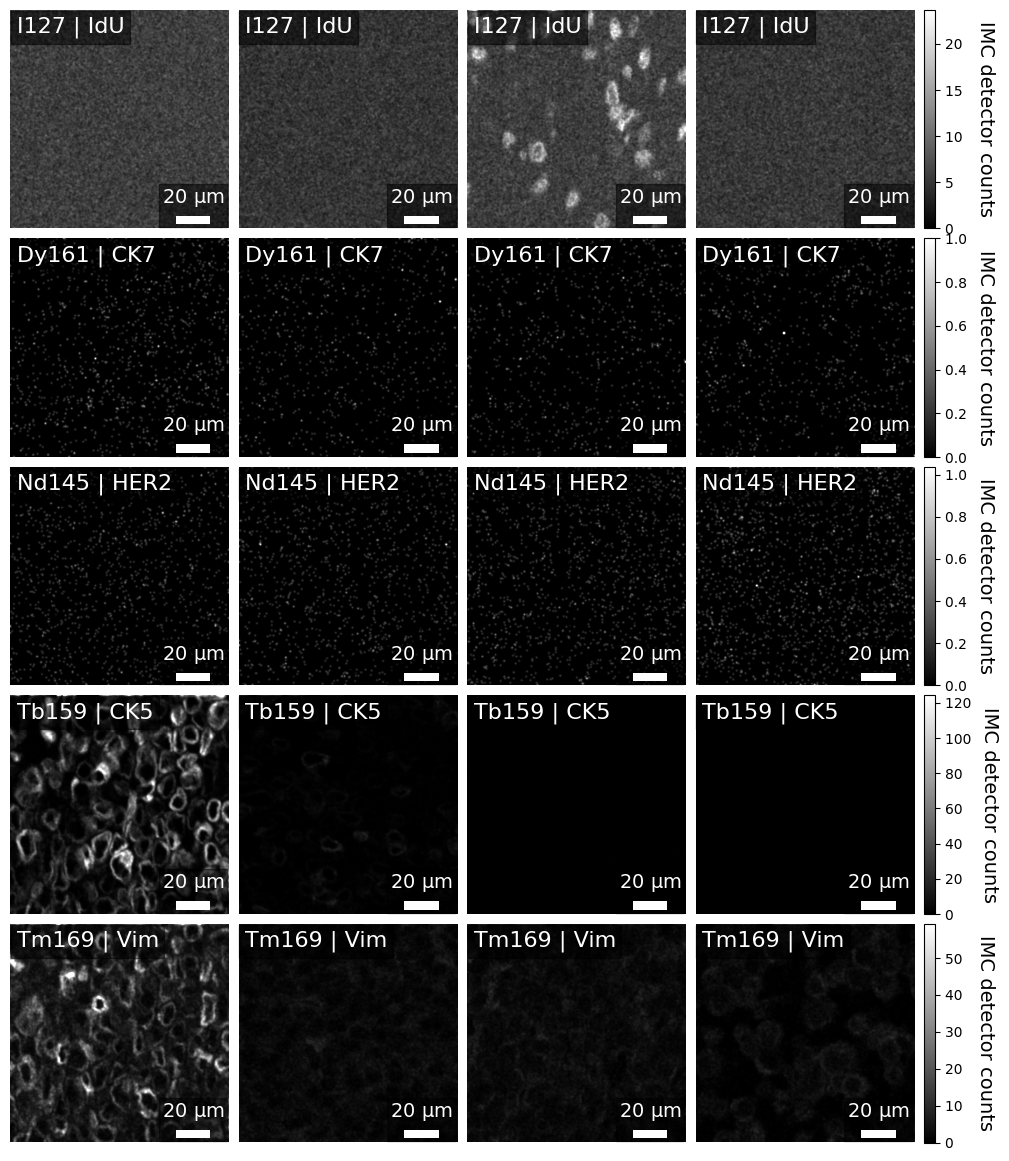

In [22]:
from importlib import reload  # Python 3.4+
reload(hph_adata)

all_channels = [
    'I_Ka',
    'La_Ka',
    'Pr_Ka',
    'Sm_Ka',
    'Gd_Ka',
    'Tb_Ka',
    'Dy_Ka',
    'Ho_Ka',
    'Tm_Ka',
    'Lu_Ka',
    'Ir_L3',
    ]

fig5_imc_channels = [
    'I_Ka',
    'Dy_Ka',
    'Nd_Ka',
    'Tb_Ka',
    'Tm_Ka'
]


hph_adata.adata_hph_channels_plot(
    adata,
    plot_channels = fig5_imc_channels,
    hdf_ids = ['MCF10a', 'A431', 'ZR-75-1', 'SKBR3'],
    plot_name= 'longname',
    plot_name_split = '(',
    legend_fontsize = 16,
    color_bar_label = 'IMC detector counts'
)

## Standard cell pellet signal to noise comparison

In [10]:
adata.obs['Hz'] = 200
df_to_map = adata.var
df_to_map['Symbol'] = df_to_map['xrf_emission'].str.split('_', expand=True).iloc[:,0]
df_to_map = pd.merge(df_to_map, df_periodic_table[['AtomicNumber', 'Element', 'Symbol']], on='Symbol')
df_to_map = df_to_map.iloc[:-1,:]
df_to_map

shortname       longname ab_tag  tag_isotope xrf_emission  \
0       pHH3     Y89 | pHH3    Y89           89         Y_Ka   
1        DNA    Rh103 | DNA  Rh103          103        Rh_Ka   
2        IdU     I127 | IdU   I127          127         I_Ka   
3         PR     La139 | PR  La139          139        La_Ka   
4      Ki-67  Pr141 | Ki-67  Pr141          141        Pr_Ka   
5       HER2   Nd145 | HER2  Nd145          145        Nd_Ka   
6        CK5    Tb159 | CK5  Tb159          159        Tb_Ka   
7        CK7    Dy161 | CK7  Dy161          161        Dy_Ka   
8        HH3    Ho165 | HH3  Ho165          165        Ho_Ka   
9        Vim    Tm169 | Vim  Tm169          169        Tm_Ka   
10     panCK  Lu175 | panCK  Lu175          175        Lu_Ka   
11       DNA    Ir191 | DNA  Ir191          191        Ir_L3   

                   target ab_clone  stock_conc_ug_per_ml  use_conc_ug_per_mL  \
0      phospho histone h3    HTA28                   NaN                 NaN   
1                     DNA       Rh                   NaN                 NaN   
2                     IdU      IdU                   NaN                 NaN   
3   Progesterone Receptor      nan                   NaN                 NaN   
4                   Ki-67      B56                   NaN                 NaN   
5         c-erbB-2 - Her2    D8F12                   NaN                 NaN   
6           Cytokeratin 5  EP1601Y                   NaN                 NaN   
7           Cytokeratin 7   RCK105                   NaN                 NaN   
8              Histone H3     D1H2                   NaN                 NaN   
9                Vimentin  EPR3776                   NaN                 NaN   
10     Keratin Epithelial      AE3                   NaN                 NaN   
11                    DNA      nan                   NaN                 NaN   

    nuclear_segment  cell_segment Symbol  AtomicNumber       Element  
0               NaN           NaN      Y            39       Yttrium  
1               NaN           NaN     Rh            45       Rhodium  
2               NaN           NaN      I            53        Iodine  
3               NaN           NaN     La            57     Lanthanum  
4               NaN           NaN     Pr            59  Praseodymium  
5               NaN           NaN     Nd            60     Neodymium  
6               NaN           1.0     Tb            65       Terbium  
7               NaN           NaN     Dy            66    Dysprosium  
8               1.0           NaN     Ho            67       Holmium  
9               NaN           1.0     Tm            69       Thulium  
10              NaN           1.0     Lu            71      Lutetium  
11              1.0           NaN     Ir            77       Iridium

In [11]:
df_signal_to_noise = pd.DataFrame()
for hz in adata.obs['Hz'].unique():
    row = {}
    row['Hz'] = hz
    adata_Hz = adata[adata.obs['Hz'] == hz]
    for var_name in adata_Hz.var_names:
        row['var_name'] = var_name

        var_values = adata_Hz[:,var_name].X

        # Sample the max and mean signal in top and bottom (specified) % of cells
        non_zero_values = sorted(var_values[np.nonzero(var_values)])
        percentage = 1
        cell_sample = int(len(non_zero_values) / 100) * percentage
        row['minval'] = np.mean(non_zero_values[:cell_sample])
        row['maxval'] = np.max(non_zero_values[-cell_sample:])

        # Add rows to dataframe
        if df_signal_to_noise.empty:
            df_signal_to_noise = pd.DataFrame(columns=row.keys())            
        df_signal_to_noise = df_signal_to_noise.append(row, ignore_index=True)
            
# # Sort data types
df_signal_to_noise['var_name'] = df_signal_to_noise['var_name'].astype('category')
df_signal_to_noise['Hz'] = df_signal_to_noise['Hz'].astype('category')
df_signal_to_noise['minval'] = df_signal_to_noise['minval'].astype('float')
df_signal_to_noise['maxval'] = df_signal_to_noise['maxval'].astype('float')
df_signal_to_noise['signal-to-noise'] = (df_signal_to_noise['maxval'] - (df_signal_to_noise['minval']))
 
# df_signal_to_noise[['ab_tag', 'shortname']] = df_signal_to_noise['var_name'].str.split(' ', expand=True).iloc[:,[0,2]].rename(columns={0:'ab_tag', 1:'shortname'})
df_signal_to_noise = pd.merge(df_signal_to_noise, df_to_map, left_on='var_name', right_on='xrf_emission', suffixes=('', '_y'))
df_signal_to_noise.drop(df_signal_to_noise.filter(regex='_y$').columns, axis=1, inplace=True)
df_signal_to_noise['Method'] = 'IMC'
df_signal_to_noise = df_signal_to_noise.iloc[:-1,:]
df_signal_to_noise


C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories

Hz var_name     minval      maxval  signal-to-noise shortname  \
0   200     Y_Ka   0.107444    1.584786         1.477341      pHH3   
1   200    Rh_Ka   1.897774   13.527220        11.629446       DNA   
2   200     I_Ka   4.473842   14.697777        10.223935       IdU   
3   200    La_Ka   0.125861    2.062857         1.936996        PR   
4   200    Pr_Ka   0.029404   24.022785        23.993381     Ki-67   
5   200    Nd_Ka   0.003718    0.066955         0.063237      HER2   
6   200    Tb_Ka   0.021459   56.178902        56.157443       CK5   
7   200    Dy_Ka   0.003290    0.076938         0.073648       CK7   
8   200    Ho_Ka  49.245026  577.313660       528.068634       HH3   
9   200    Tm_Ka   1.036424   31.523304        30.486880       Vim   
10  200    Lu_Ka   0.285783   90.118202        89.832419     panCK   
11  200    Ir_L3   0.061054    7.973130         7.912076       DNA   

         longname ab_tag  tag_isotope xrf_emission                 target  \
0      Y89 | pHH3    Y89           89         Y_Ka     phospho histone h3   
1     Rh103 | DNA  Rh103          103        Rh_Ka                    DNA   
2      I127 | IdU   I127          127         I_Ka                    IdU   
3      La139 | PR  La139          139        La_Ka  Progesterone Receptor   
4   Pr141 | Ki-67  Pr141          141        Pr_Ka                  Ki-67   
5    Nd145 | HER2  Nd145          145        Nd_Ka        c-erbB-2 - Her2   
6     Tb159 | CK5  Tb159          159        Tb_Ka          Cytokeratin 5   
7     Dy161 | CK7  Dy161          161        Dy_Ka          Cytokeratin 7   
8     Ho165 | HH3  Ho165          165        Ho_Ka             Histone H3   
9     Tm169 | Vim  Tm169          169        Tm_Ka               Vimentin   
10  Lu175 | panCK  Lu175          175        Lu_Ka     Keratin Epithelial   
11    Ir191 | DNA  Ir191          191        Ir_L3                    DNA   

   ab_clone  stock_conc_ug_per_ml  use_conc_ug_per_mL  nuclear_segment  \
0     HTA28                   NaN                 NaN              NaN   
1        Rh                   NaN                 NaN              NaN   
2       IdU                   NaN                 NaN              NaN   
3       nan                   NaN                 NaN              NaN   
4       B56                   NaN                 NaN              NaN   
5     D8F12                   NaN                 NaN              NaN   
6   EP1601Y                   NaN                 NaN              NaN   
7    RCK105                   NaN                 NaN              NaN   
8      D1H2                   NaN                 NaN              1.0   
9   EPR3776                   NaN                 NaN              NaN   
10      AE3                   NaN                 NaN              NaN   
11      nan                   NaN                 NaN              1.0   

    cell_segment Symbol  AtomicNumber       Element Method  
0            NaN      Y            39       Yttrium    IMC  
1            NaN     Rh            45       Rhodium    IMC  
2            NaN      I            53        Iodine    IMC  
3            NaN     La            57     Lanthanum    IMC  
4            NaN     Pr            59  Praseodymium    IMC  
5            NaN     Nd            60     Neodymium    IMC  
6            1.0     Tb            65       Terbium    IMC  
7            NaN     Dy            66    Dysprosium    IMC  
8            NaN     Ho            67       Holmium    IMC  
9            1.0     Tm            69       Thulium    IMC  
10           1.0     Lu            71      Lutetium    IMC  
11           NaN     Ir            77       Iridium    IMC

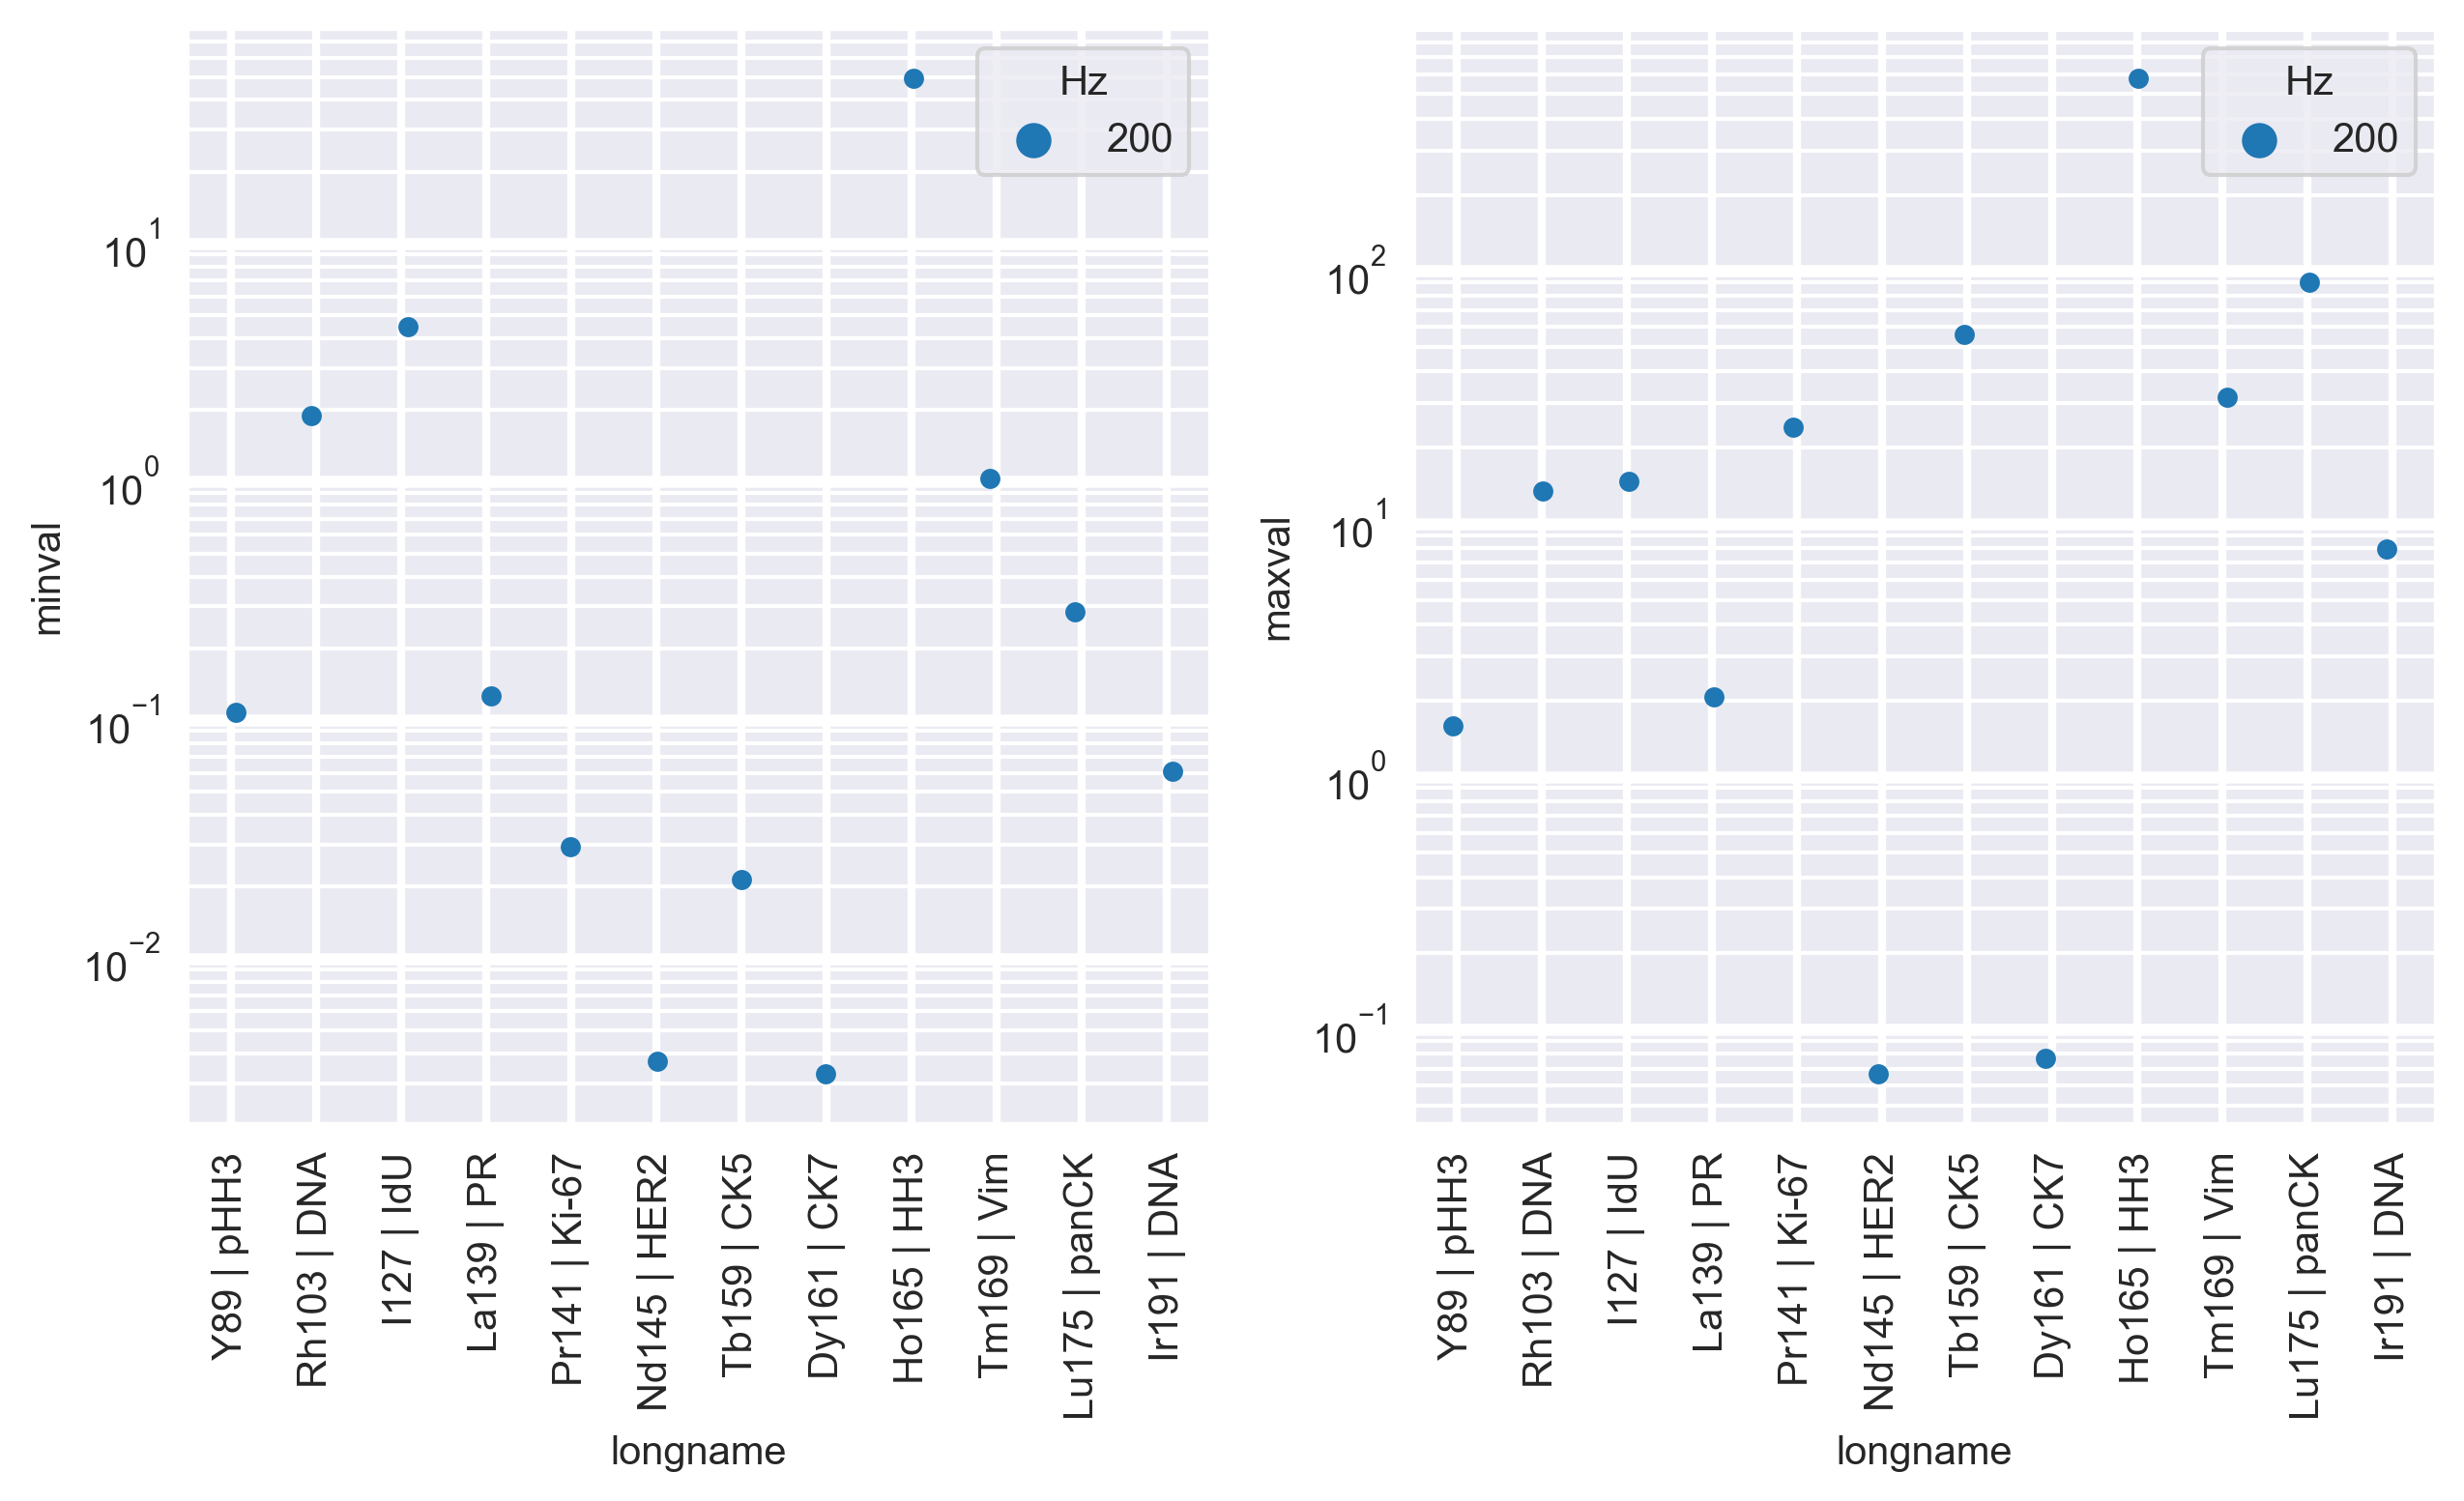

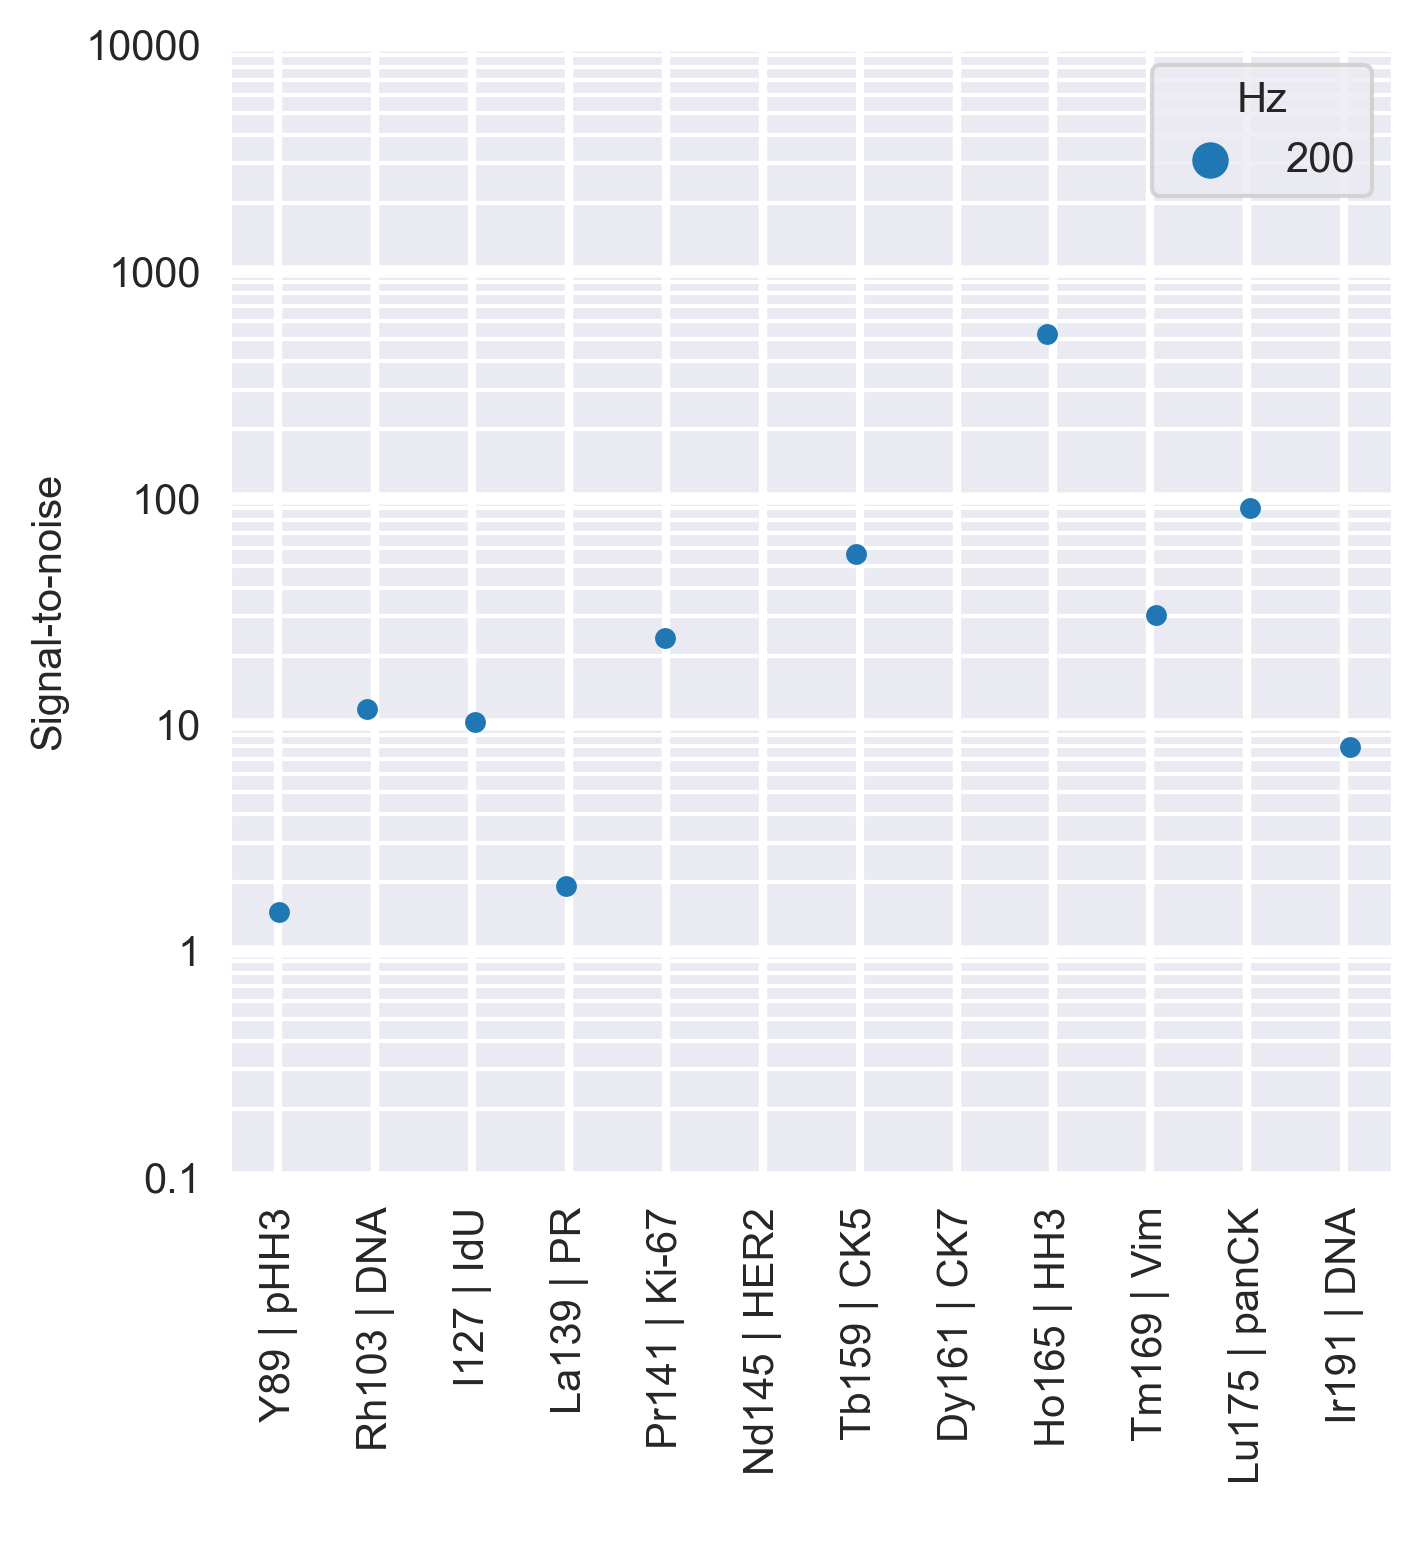

In [12]:
# Set seaborn
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

sns.set_style("dark")

### Check max and min values
fig, axs = plt.subplots(ncols = 2, figsize=(10,5), dpi=300)

g = sns.stripplot(
    data = df_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'minval',
    ax=axs[0],
    hue='Hz'
)
axs[0].tick_params(axis='x', rotation=90)

# Set scale
g.set(yscale="log")
#Set gridlines
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')

g = sns.stripplot(
    data = df_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'maxval',
    ax=axs[1],
    hue='Hz',
)
axs[1].tick_params(axis='x', rotation=90)


# Set scale
g.set(yscale="log")
#Set gridlines
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')

# Sort shared legend
# axs[0].get_legend().remove()
# axs[1].get_legend().remove()
# plt.legend(title='Raster rate (Hz)', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=90)#, ha='right')
plt.show()

### Plot signal to noise
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
g = sns.stripplot(
    data = df_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'signal-to-noise',
    ax=ax,
    hue='Hz'
)
ax.set(yscale="log")
ax.set_ylim([0.1, 10000])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')
plt.xticks(rotation=90)#, ha='right')
plt.ylabel('Signal-to-noise')
plt.xlabel(' ')
# plt.legend(title='Raster rate (Hz)', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

## IMC and XRF signal to noise of speed cell pellets

In [13]:
adata_xrf_path = pathlib.Path(r'C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/processed/xrf/7b_SABER_cell_quantification/cell_pellet_standard_for_signal_to_noise_matched_cell_mask.h5ad')
adata_xrf_path.exists()

adata_xrf = ad.read_h5ad(adata_xrf_path)
adata_xrf.var


shortname        longname
Dy_Ka      CK 7    Dy_Ka | CK 7
Ho_Ka       HH3     Ho_Ka | HH3
I_Ka        IdU      I_Ka | IdU
Ir_L3       DNA     Ir_L3 | DNA
La_Ka        PR      La_Ka | PR
Lu_Ka    pan CK  Lu_Ka | pan CK
Nd_Ka      HER2    Nd_Ka | HER2
Pr_Ka     Ki-67   Pr_Ka | Ki-67
Rh_Ka       DNA     Rh_Ka | DNA
Tb_Ka       CK5     Tb_Ka | CK5
Tm_Ka       Vim     Tm_Ka | Vim
Y_Ka       pHH3     Y_Ka | pHH3

In [14]:
df_xrf_signal_to_noise = pd.DataFrame()
for hz in adata_xrf.obs['Hz'].unique():
    row = {}
    row['Hz'] = hz
    adata_Hz = adata_xrf[adata_xrf.obs['Hz'] == hz]
    for var_name in adata_Hz.var_names:
        row['var_name'] = var_name

        var_values = adata_Hz[:,var_name].X

        # Sample the max and mean signal in top and bottom (specified) % of cells
        non_zero_values = sorted(var_values[np.nonzero(var_values)])
        percentage = 1
        cell_sample = int(len(non_zero_values) / 100) * percentage
        row['minval'] = np.mean(non_zero_values[:cell_sample])
        row['maxval'] = np.max(non_zero_values[-cell_sample:])

        # Add rows to dataframe
        if df_xrf_signal_to_noise.empty:
            df_xrf_signal_to_noise = pd.DataFrame(columns=row.keys())            
        df_xrf_signal_to_noise = df_xrf_signal_to_noise.append(row, ignore_index=True)
            
# # Sort data types
df_xrf_signal_to_noise['var_name'] = df_xrf_signal_to_noise['var_name'].astype('category')
df_xrf_signal_to_noise['Hz'] = df_xrf_signal_to_noise['Hz'].astype('category')
df_xrf_signal_to_noise['minval'] = df_xrf_signal_to_noise['minval'].astype('float')
df_xrf_signal_to_noise['maxval'] = df_xrf_signal_to_noise['maxval'].astype('float')
df_xrf_signal_to_noise['signal-to-noise'] = (df_xrf_signal_to_noise['maxval'] - (df_xrf_signal_to_noise['minval']))
 
df_xrf_signal_to_noise['xrf_emission'] = df_xrf_signal_to_noise['var_name'].str.split(' ', expand=True).iloc[:,0]
# df_xrf_signal_to_noise[['ab_tag', 'shortname']] = df_xrf_signal_to_noise['var_name'].str.split(' ', expand=True).iloc[:,[0,2]].rename(columns={0:'ab_tag', 1:'shortname'})
df_xrf_signal_to_noise = pd.merge(df_xrf_signal_to_noise, df_to_map, left_on='xrf_emission', right_on='xrf_emission', suffixes=('', '_y'))
df_xrf_signal_to_noise.drop(df_xrf_signal_to_noise.filter(regex='_y$').columns, axis=1, inplace=True)
df_xrf_signal_to_noise['Method'] = 'XRF (GeCMOS 2nd)'
df_xrf_signal_to_noise

C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Hz var_name      minval      maxval  signal-to-noise xrf_emission  \
0    10    Dy_Ka   45.338234   66.433022        21.094788        Dy_Ka   
1    50    Dy_Ka    8.759016   13.845051         5.086035        Dy_Ka   
2   250    Dy_Ka    1.578791    2.389756         0.810965        Dy_Ka   
3    10    Ho_Ka  183.340103  791.718140       608.378036        Ho_Ka   
4    50    Ho_Ka   35.423214  160.390549       124.967335        Ho_Ka   
5   250    Ho_Ka    6.611490   27.879381        21.267891        Ho_Ka   
6    10     I_Ka    5.641575  137.133057       131.491482         I_Ka   
7    50     I_Ka    1.024117   24.788799        23.764682         I_Ka   
8   250     I_Ka    0.180803    4.702416         4.521613         I_Ka   
9    10    Ir_L3   19.042202   28.786438         9.744236        Ir_L3   
10   50    Ir_L3    3.534501    5.997414         2.462913        Ir_L3   
11  250    Ir_L3    0.598062    1.054006         0.455943        Ir_L3   
12   10    La_Ka    5.476617   13.357019         7.880403        La_Ka   
13   50    La_Ka    1.007715    2.632566         1.624851        La_Ka   
14  250    La_Ka    0.162445    0.464362         0.301916        La_Ka   
15   10    Lu_Ka   89.510902  282.537415       193.026512        Lu_Ka   
16   50    Lu_Ka   22.509893   68.905876        46.395983        Lu_Ka   
17  250    Lu_Ka    4.250408   14.458211        10.207803        Lu_Ka   
18   10    Nd_Ka    5.583941   16.270109        10.686168        Nd_Ka   
19   50    Nd_Ka    1.048362    3.249938         2.201576        Nd_Ka   
20  250    Nd_Ka    0.189506    0.665735         0.476229        Nd_Ka   
21   10    Pr_Ka    4.500294   41.373123        36.872829        Pr_Ka   
22   50    Pr_Ka    0.807197    6.634513         5.827317        Pr_Ka   
23  250    Pr_Ka    0.125769    1.216943         1.091174        Pr_Ka   
24   10    Rh_Ka   19.052622  129.151794       110.099173        Rh_Ka   
25   50    Rh_Ka    3.497158   24.698877        21.201719        Rh_Ka   
26  250    Rh_Ka    0.587500    4.454413         3.866913        Rh_Ka   
27   10    Tb_Ka   27.196733  127.838165       100.641432        Tb_Ka   
28   50    Tb_Ka    5.521491   24.604876        19.083385        Tb_Ka   
29  250    Tb_Ka    0.940636    4.379187         3.438550        Tb_Ka   
30   10    Tm_Ka  125.320908  167.638885        42.317978        Tm_Ka   
31   50    Tm_Ka   26.708221   38.787651        12.079430        Tm_Ka   
32  250    Tm_Ka    4.505149    6.470889         1.965739        Tm_Ka   
33   10     Y_Ka    6.190505   10.496214         4.305709         Y_Ka   
34   50     Y_Ka    1.171412    2.856490         1.685078         Y_Ka   
35  250     Y_Ka    0.187084    0.434108         0.247024         Y_Ka   

   shortname       longname ab_tag  tag_isotope                 target  \
0        CK7    Dy161 | CK7  Dy161          161          Cytokeratin 7   
1        CK7    Dy161 | CK7  Dy161          161          Cytokeratin 7   
2        CK7    Dy161 | CK7  Dy161          161          Cytokeratin 7   
3        HH3    Ho165 | HH3  Ho165          165             Histone H3   
4        HH3    Ho165 | HH3  Ho165          165             Histone H3   
5        HH3    Ho165 | HH3  Ho165          165             Histone H3   
6        IdU     I127 | IdU   I127          127                    IdU   
7        IdU     I127 | IdU   I127          127                    IdU   
8        IdU     I127 | IdU   I127          127                    IdU   
9        DNA    Ir191 | DNA  Ir191          191                    DNA   
10       DNA    Ir191 | DNA  Ir191          191                    DNA   
11       DNA    Ir191 | DNA  Ir191          191                    DNA   
12        PR     La139 | PR  La139          139  Progesterone Receptor   
13        PR     La139 | PR  La139          139  Progesterone Receptor   
14        PR     La139 | PR  La139          139  Progesterone Receptor   
15     panCK  Lu175 | panCK  Lu175          175     Keratin Epithelial   
16     p

In [15]:
df_collated_signal_to_noise = df_signal_to_noise[['Hz', 'minval', 'maxval', 'signal-to-noise', 'ab_tag', 'Symbol', 'longname', 'AtomicNumber', 'Element', 'Method']]
df_collated_signal_to_noise = df_collated_signal_to_noise.append(df_xrf_signal_to_noise[df_collated_signal_to_noise.columns], ignore_index=True)
df_collated_signal_to_noise['Hz'] = df_collated_signal_to_noise['Hz'].astype('int')
# df_collated_signal_to_noise = df_collated_signal_to_noise[df_collated_signal_to_noise['Symbol'] != 'Ir']

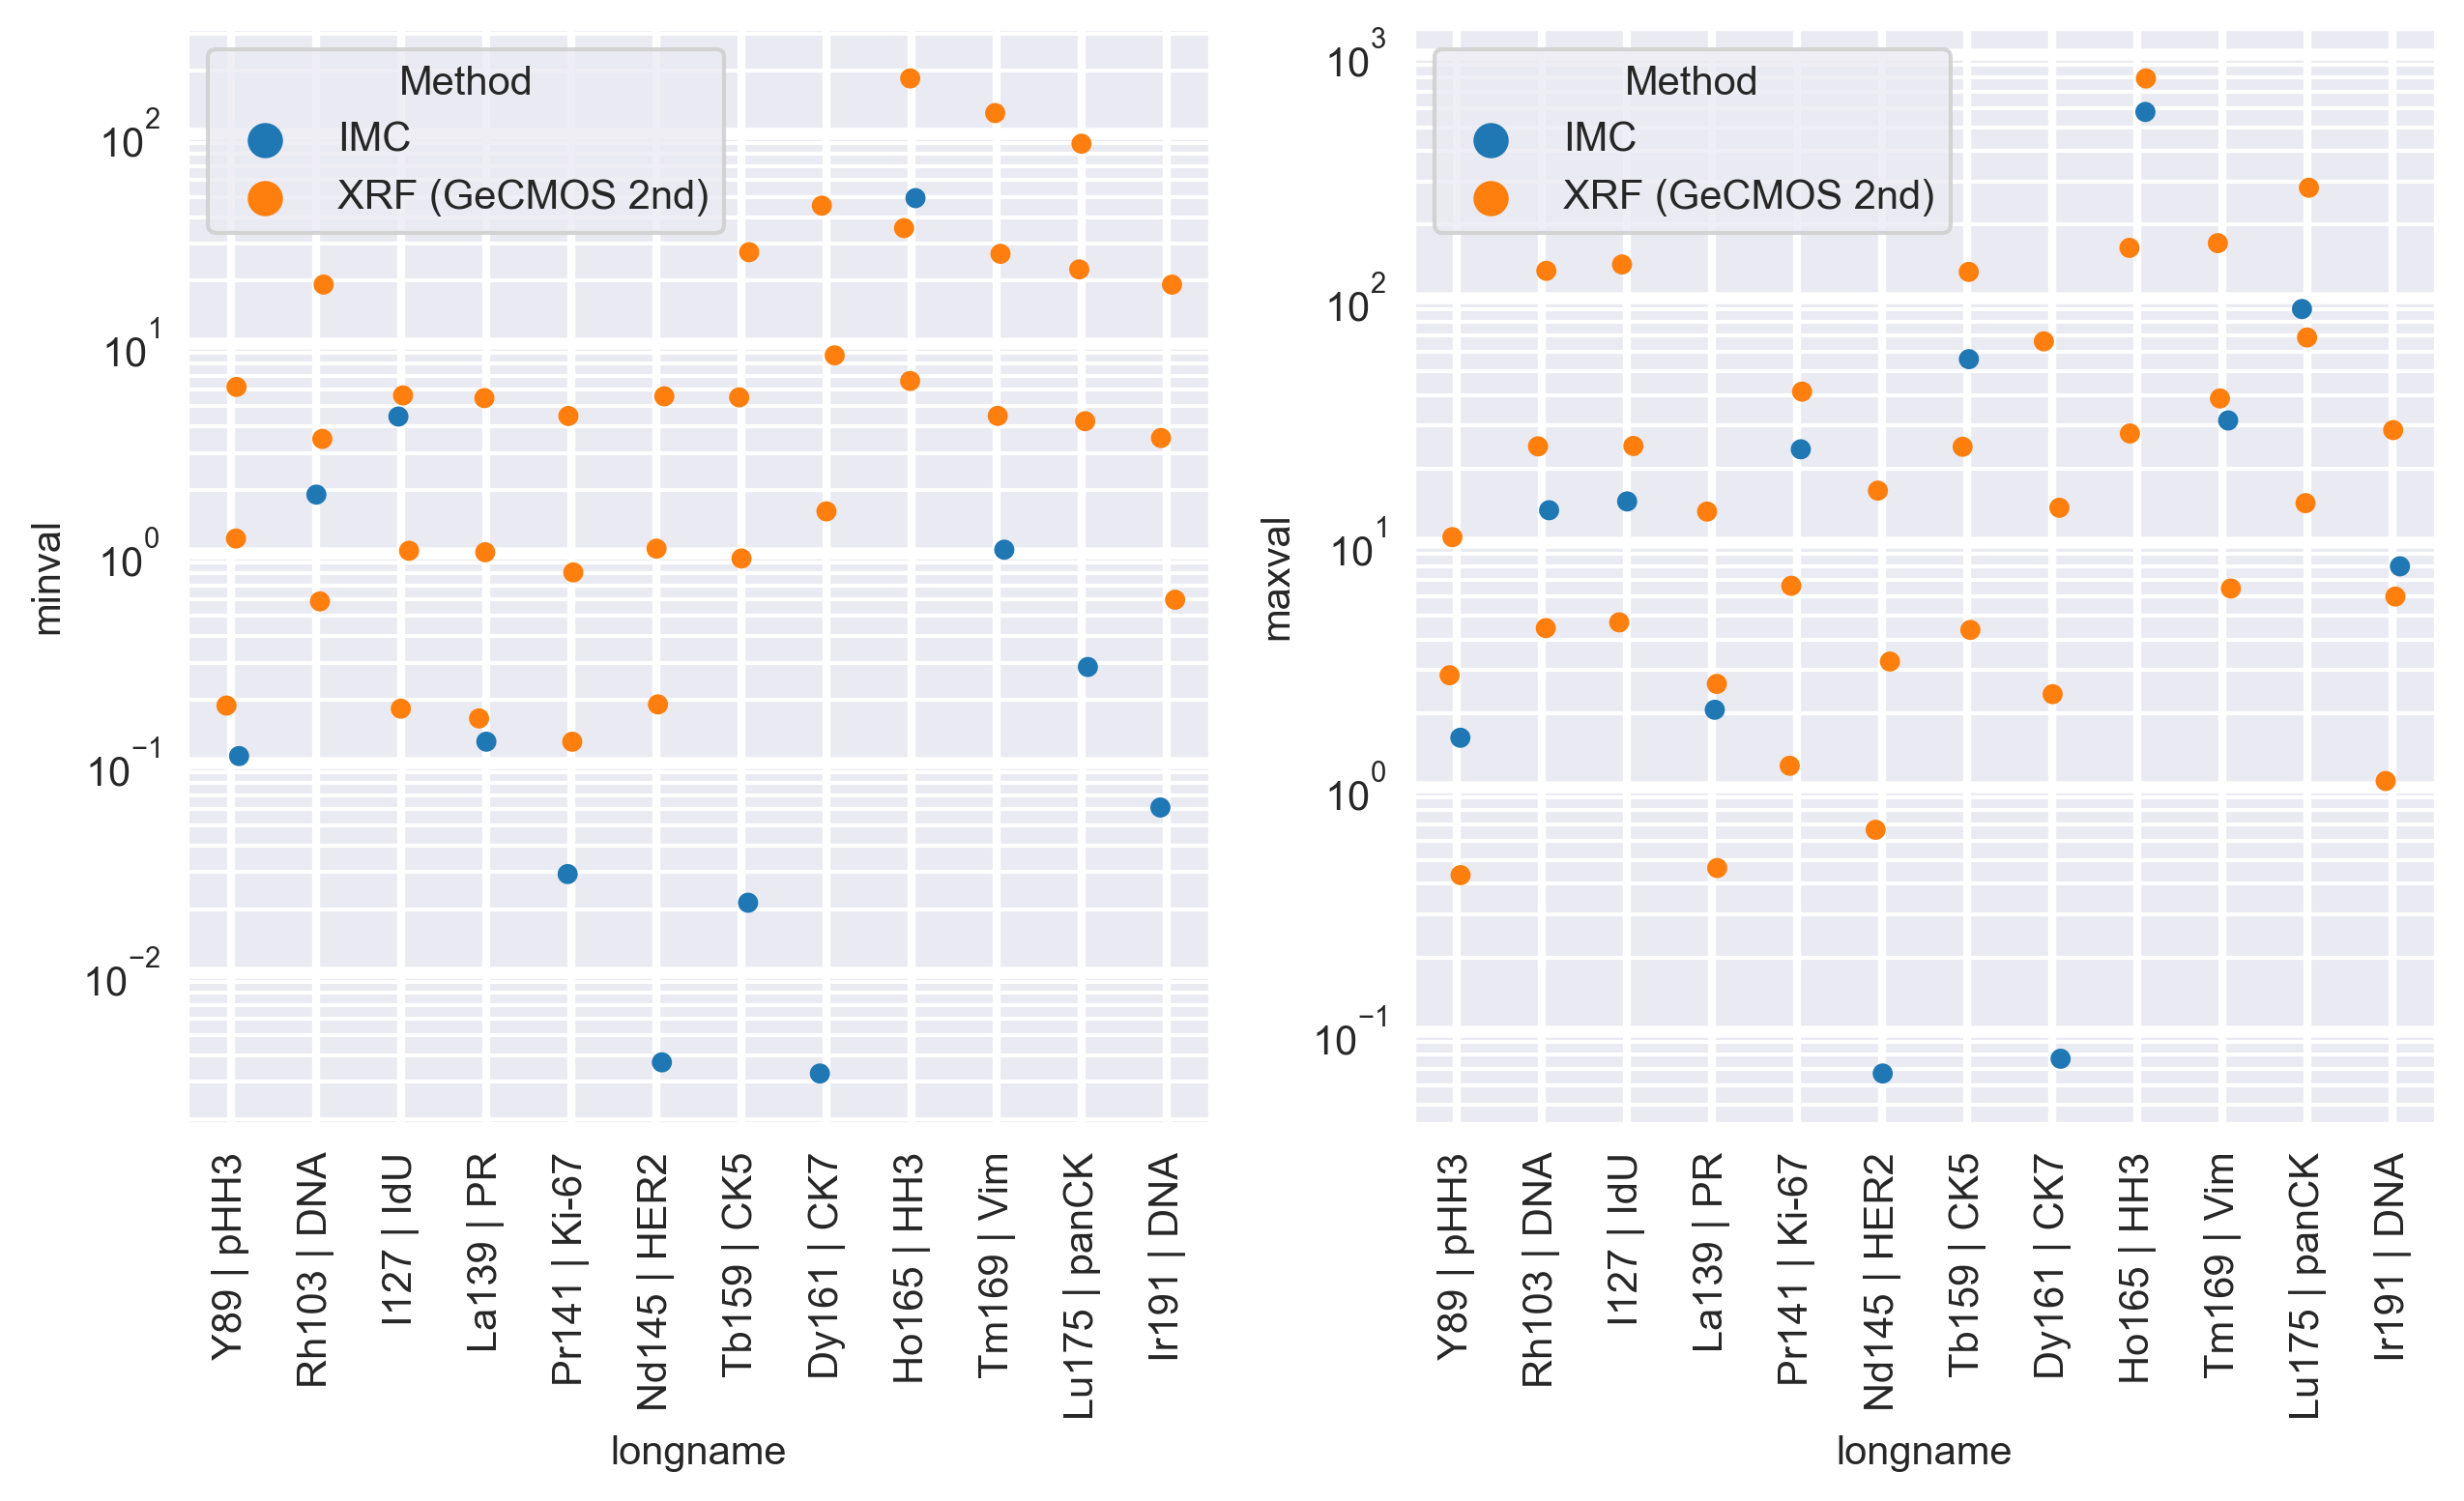

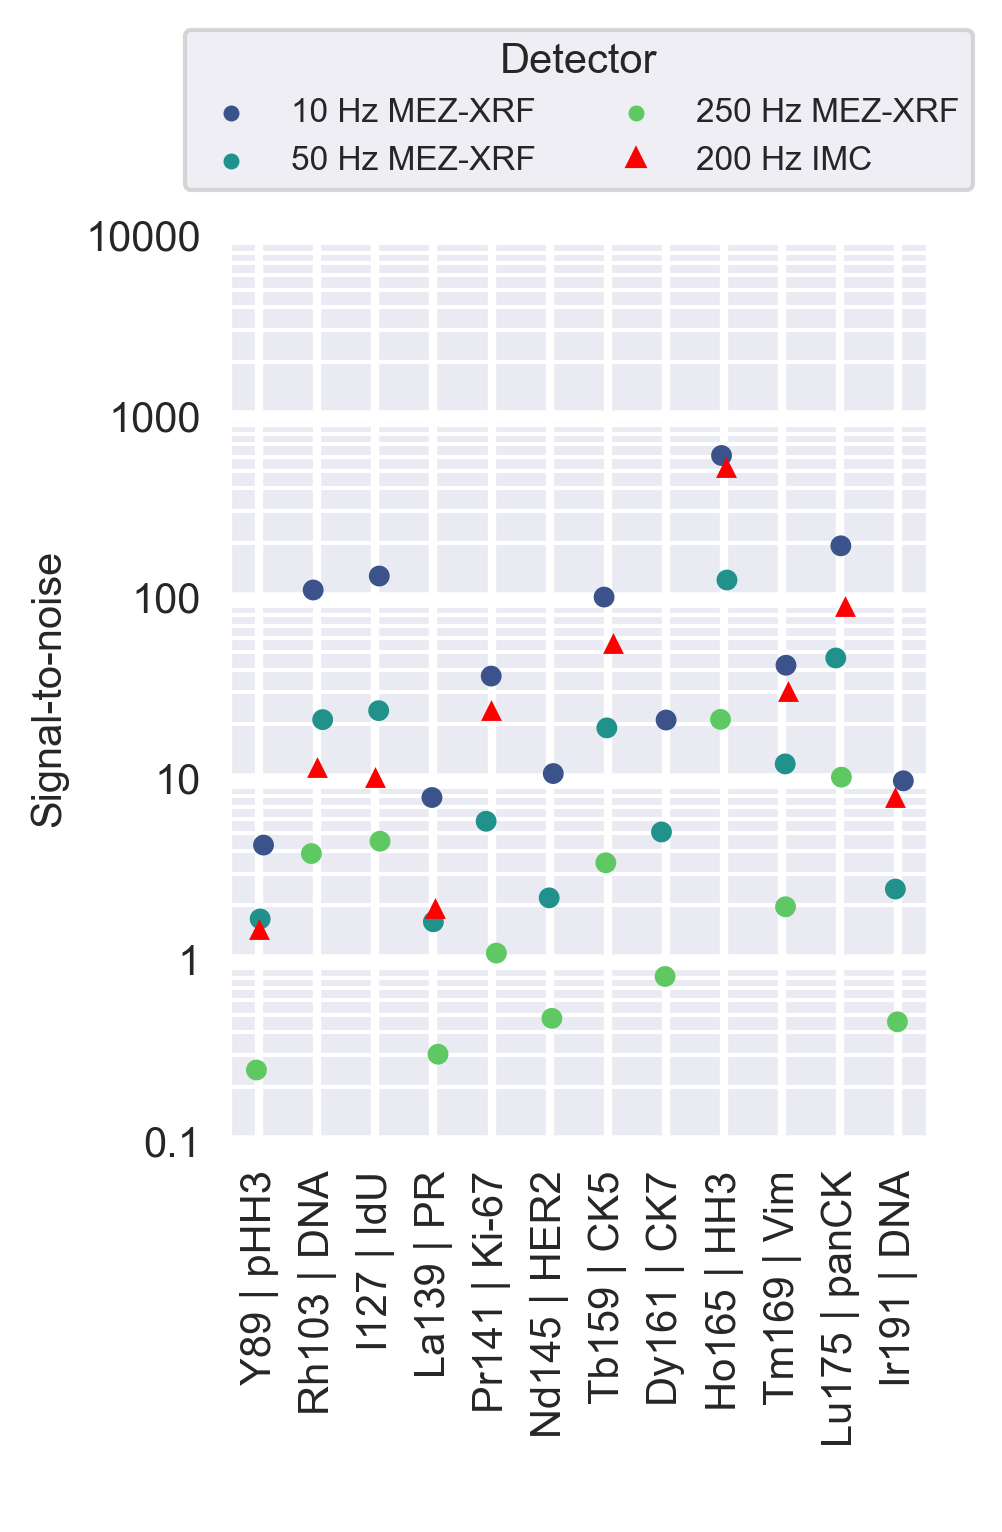

In [16]:
# Set seaborn
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

sns.set_style("dark")

### Check max and min values
fig, axs = plt.subplots(ncols = 2, figsize=(10,5), dpi=300)

g = sns.stripplot(
    data = df_collated_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'minval',
    ax=axs[0],
    hue='Method'
)
axs[0].tick_params(axis='x', rotation=90)

# Set scale
g.set(yscale="log")
#Set gridlines
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')

g = sns.stripplot(
    data = df_collated_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'maxval',
    ax=axs[1],
    hue='Method'
)
axs[1].tick_params(axis='x', rotation=90)

# Set scale
g.set(yscale="log")
#Set gridlines
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')

plt.xticks(rotation=90)#, ha='right')
plt.show()

### Plot signal to noise
fig, ax = plt.subplots(figsize=(3,4), dpi=300)
g = sns.stripplot(
    data = df_collated_signal_to_noise[df_collated_signal_to_noise['Method'] == 'XRF (GeCMOS 2nd)'],
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'signal-to-noise',
    ax=ax,
    hue='Hz',    
    palette = 'viridis'
)

g = sns.stripplot(
    data = df_collated_signal_to_noise[df_collated_signal_to_noise['Method'] == 'IMC'],
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'signal-to-noise',
    ax=ax,
    hue='Method',  
    palette = ['red'],
    marker='^',
)

ax.set(yscale="log")
ax.set_ylim([0.1, 10000])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

# Custom set the marker for IMC
handles, labels = ax.get_legend_handles_labels()
red_triangle = mlines.Line2D([], [], color='red', marker='^', linestyle='None', markersize=4, label='Purple triangles')
handles[-1] = red_triangle

lgd = plt.legend(
    title='Detector',
    loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2,
    borderaxespad=0., 
    labels=['10 Hz MEZ-XRF', '50 Hz MEZ-XRF', '250 Hz MEZ-XRF', '200 Hz IMC'],
    handles = handles,
    fontsize=8
)

for legend_handle in lgd.legendHandles[:-1]:
    legend_handle.set_sizes([8])

g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')
plt.xticks(rotation=90)#, ha='right')
plt.ylabel('Signal-to-noise')
plt.xlabel(' ')

plt.show()

## Signal to noise comparison

In [17]:
adata.obs['Hz'] = 200
df_to_map = adata.var
df_to_map['Symbol'] = df_to_map['xrf_emission'].str.split('_', expand=True).iloc[:,0]
df_to_map = pd.merge(df_to_map, df_periodic_table[['AtomicNumber', 'Element', 'Symbol']], on='Symbol')
df_to_map = df_to_map.iloc[:-1,:]
df_to_map

shortname       longname ab_tag  tag_isotope xrf_emission  \
0       pHH3     Y89 | pHH3    Y89           89         Y_Ka   
1        DNA    Rh103 | DNA  Rh103          103        Rh_Ka   
2        IdU     I127 | IdU   I127          127         I_Ka   
3         PR     La139 | PR  La139          139        La_Ka   
4      Ki-67  Pr141 | Ki-67  Pr141          141        Pr_Ka   
5       HER2   Nd145 | HER2  Nd145          145        Nd_Ka   
6        CK5    Tb159 | CK5  Tb159          159        Tb_Ka   
7        CK7    Dy161 | CK7  Dy161          161        Dy_Ka   
8        HH3    Ho165 | HH3  Ho165          165        Ho_Ka   
9        Vim    Tm169 | Vim  Tm169          169        Tm_Ka   
10     panCK  Lu175 | panCK  Lu175          175        Lu_Ka   
11       DNA    Ir191 | DNA  Ir191          191        Ir_L3   

                   target ab_clone  stock_conc_ug_per_ml  use_conc_ug_per_mL  \
0      phospho histone h3    HTA28                   NaN                 NaN   
1                     DNA       Rh                   NaN                 NaN   
2                     IdU      IdU                   NaN                 NaN   
3   Progesterone Receptor      nan                   NaN                 NaN   
4                   Ki-67      B56                   NaN                 NaN   
5         c-erbB-2 - Her2    D8F12                   NaN                 NaN   
6           Cytokeratin 5  EP1601Y                   NaN                 NaN   
7           Cytokeratin 7   RCK105                   NaN                 NaN   
8              Histone H3     D1H2                   NaN                 NaN   
9                Vimentin  EPR3776                   NaN                 NaN   
10     Keratin Epithelial      AE3                   NaN                 NaN   
11                    DNA      nan                   NaN                 NaN   

    nuclear_segment  cell_segment Symbol  AtomicNumber       Element  
0               NaN           NaN      Y            39       Yttrium  
1               NaN           NaN     Rh            45       Rhodium  
2               NaN           NaN      I            53        Iodine  
3               NaN           NaN     La            57     Lanthanum  
4               NaN           NaN     Pr            59  Praseodymium  
5               NaN           NaN     Nd            60     Neodymium  
6               NaN           1.0     Tb            65       Terbium  
7               NaN           NaN     Dy            66    Dysprosium  
8               1.0           NaN     Ho            67       Holmium  
9               NaN           1.0     Tm            69       Thulium  
10              NaN           1.0     Lu            71      Lutetium  
11              1.0           NaN     Ir            77       Iridium

In [18]:
df_signal_to_noise = pd.DataFrame()
for hz in adata.obs['Hz'].unique():
    row = {}
    row['Hz'] = hz
    adata_Hz = adata[adata.obs['Hz'] == hz]
    for var_name in adata_Hz.var_names:
        row['var_name'] = var_name

        var_values = adata_Hz[:,var_name].X

        # Sample the max and mean signal in top and bottom (specified) % of cells
        non_zero_values = sorted(var_values[np.nonzero(var_values)])
        percentage = 1
        cell_sample = int(len(non_zero_values) / 100) * percentage
        row['minval'] = np.mean(non_zero_values[:cell_sample])
        row['maxval'] = np.max(non_zero_values[-cell_sample:])

        # Add rows to dataframe
        if df_signal_to_noise.empty:
            df_signal_to_noise = pd.DataFrame(columns=row.keys())            
        df_signal_to_noise = df_signal_to_noise.append(row, ignore_index=True)
            
# # Sort data types
df_signal_to_noise['var_name'] = df_signal_to_noise['var_name'].astype('category')
df_signal_to_noise['Hz'] = df_signal_to_noise['Hz'].astype('category')
df_signal_to_noise['minval'] = df_signal_to_noise['minval'].astype('float')
df_signal_to_noise['maxval'] = df_signal_to_noise['maxval'].astype('float')
df_signal_to_noise['signal-to-noise'] = (df_signal_to_noise['maxval'] - (df_signal_to_noise['minval']))
 
# df_signal_to_noise[['ab_tag', 'shortname']] = df_signal_to_noise['var_name'].str.split(' ', expand=True).iloc[:,[0,2]].rename(columns={0:'ab_tag', 1:'shortname'})
df_signal_to_noise = pd.merge(df_signal_to_noise, df_to_map, left_on='var_name', right_on='xrf_emission', suffixes=('', '_y'))
df_signal_to_noise.drop(df_signal_to_noise.filter(regex='_y$').columns, axis=1, inplace=True)
df_signal_to_noise['Method'] = 'IMC'
df_signal_to_noise = df_signal_to_noise.iloc[:-1,:]
df_signal_to_noise


C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories

Hz var_name     minval      maxval  signal-to-noise shortname  \
0   200     Y_Ka   0.107444    1.584786         1.477341      pHH3   
1   200    Rh_Ka   1.897774   13.527220        11.629446       DNA   
2   200     I_Ka   4.473842   14.697777        10.223935       IdU   
3   200    La_Ka   0.125861    2.062857         1.936996        PR   
4   200    Pr_Ka   0.029404   24.022785        23.993381     Ki-67   
5   200    Nd_Ka   0.003718    0.066955         0.063237      HER2   
6   200    Tb_Ka   0.021459   56.178902        56.157443       CK5   
7   200    Dy_Ka   0.003290    0.076938         0.073648       CK7   
8   200    Ho_Ka  49.245026  577.313660       528.068634       HH3   
9   200    Tm_Ka   1.036424   31.523304        30.486880       Vim   
10  200    Lu_Ka   0.285783   90.118202        89.832419     panCK   
11  200    Ir_L3   0.061054    7.973130         7.912076       DNA   

         longname ab_tag  tag_isotope xrf_emission                 target  \
0      Y89 | pHH3    Y89           89         Y_Ka     phospho histone h3   
1     Rh103 | DNA  Rh103          103        Rh_Ka                    DNA   
2      I127 | IdU   I127          127         I_Ka                    IdU   
3      La139 | PR  La139          139        La_Ka  Progesterone Receptor   
4   Pr141 | Ki-67  Pr141          141        Pr_Ka                  Ki-67   
5    Nd145 | HER2  Nd145          145        Nd_Ka        c-erbB-2 - Her2   
6     Tb159 | CK5  Tb159          159        Tb_Ka          Cytokeratin 5   
7     Dy161 | CK7  Dy161          161        Dy_Ka          Cytokeratin 7   
8     Ho165 | HH3  Ho165          165        Ho_Ka             Histone H3   
9     Tm169 | Vim  Tm169          169        Tm_Ka               Vimentin   
10  Lu175 | panCK  Lu175          175        Lu_Ka     Keratin Epithelial   
11    Ir191 | DNA  Ir191          191        Ir_L3                    DNA   

   ab_clone  stock_conc_ug_per_ml  use_conc_ug_per_mL  nuclear_segment  \
0     HTA28                   NaN                 NaN              NaN   
1        Rh                   NaN                 NaN              NaN   
2       IdU                   NaN                 NaN              NaN   
3       nan                   NaN                 NaN              NaN   
4       B56                   NaN                 NaN              NaN   
5     D8F12                   NaN                 NaN              NaN   
6   EP1601Y                   NaN                 NaN              NaN   
7    RCK105                   NaN                 NaN              NaN   
8      D1H2                   NaN                 NaN              1.0   
9   EPR3776                   NaN                 NaN              NaN   
10      AE3                   NaN                 NaN              NaN   
11      nan                   NaN                 NaN              1.0   

    cell_segment Symbol  AtomicNumber       Element Method  
0            NaN      Y            39       Yttrium    IMC  
1            NaN     Rh            45       Rhodium    IMC  
2            NaN      I            53        Iodine    IMC  
3            NaN     La            57     Lanthanum    IMC  
4            NaN     Pr            59  Praseodymium    IMC  
5            NaN     Nd            60     Neodymium    IMC  
6            1.0     Tb            65       Terbium    IMC  
7            NaN     Dy            66    Dysprosium    IMC  
8            NaN     Ho            67       Holmium    IMC  
9            1.0     Tm            69       Thulium    IMC  
10           1.0     Lu            71      Lutetium    IMC  
11           NaN     Ir            77       Iridium    IMC

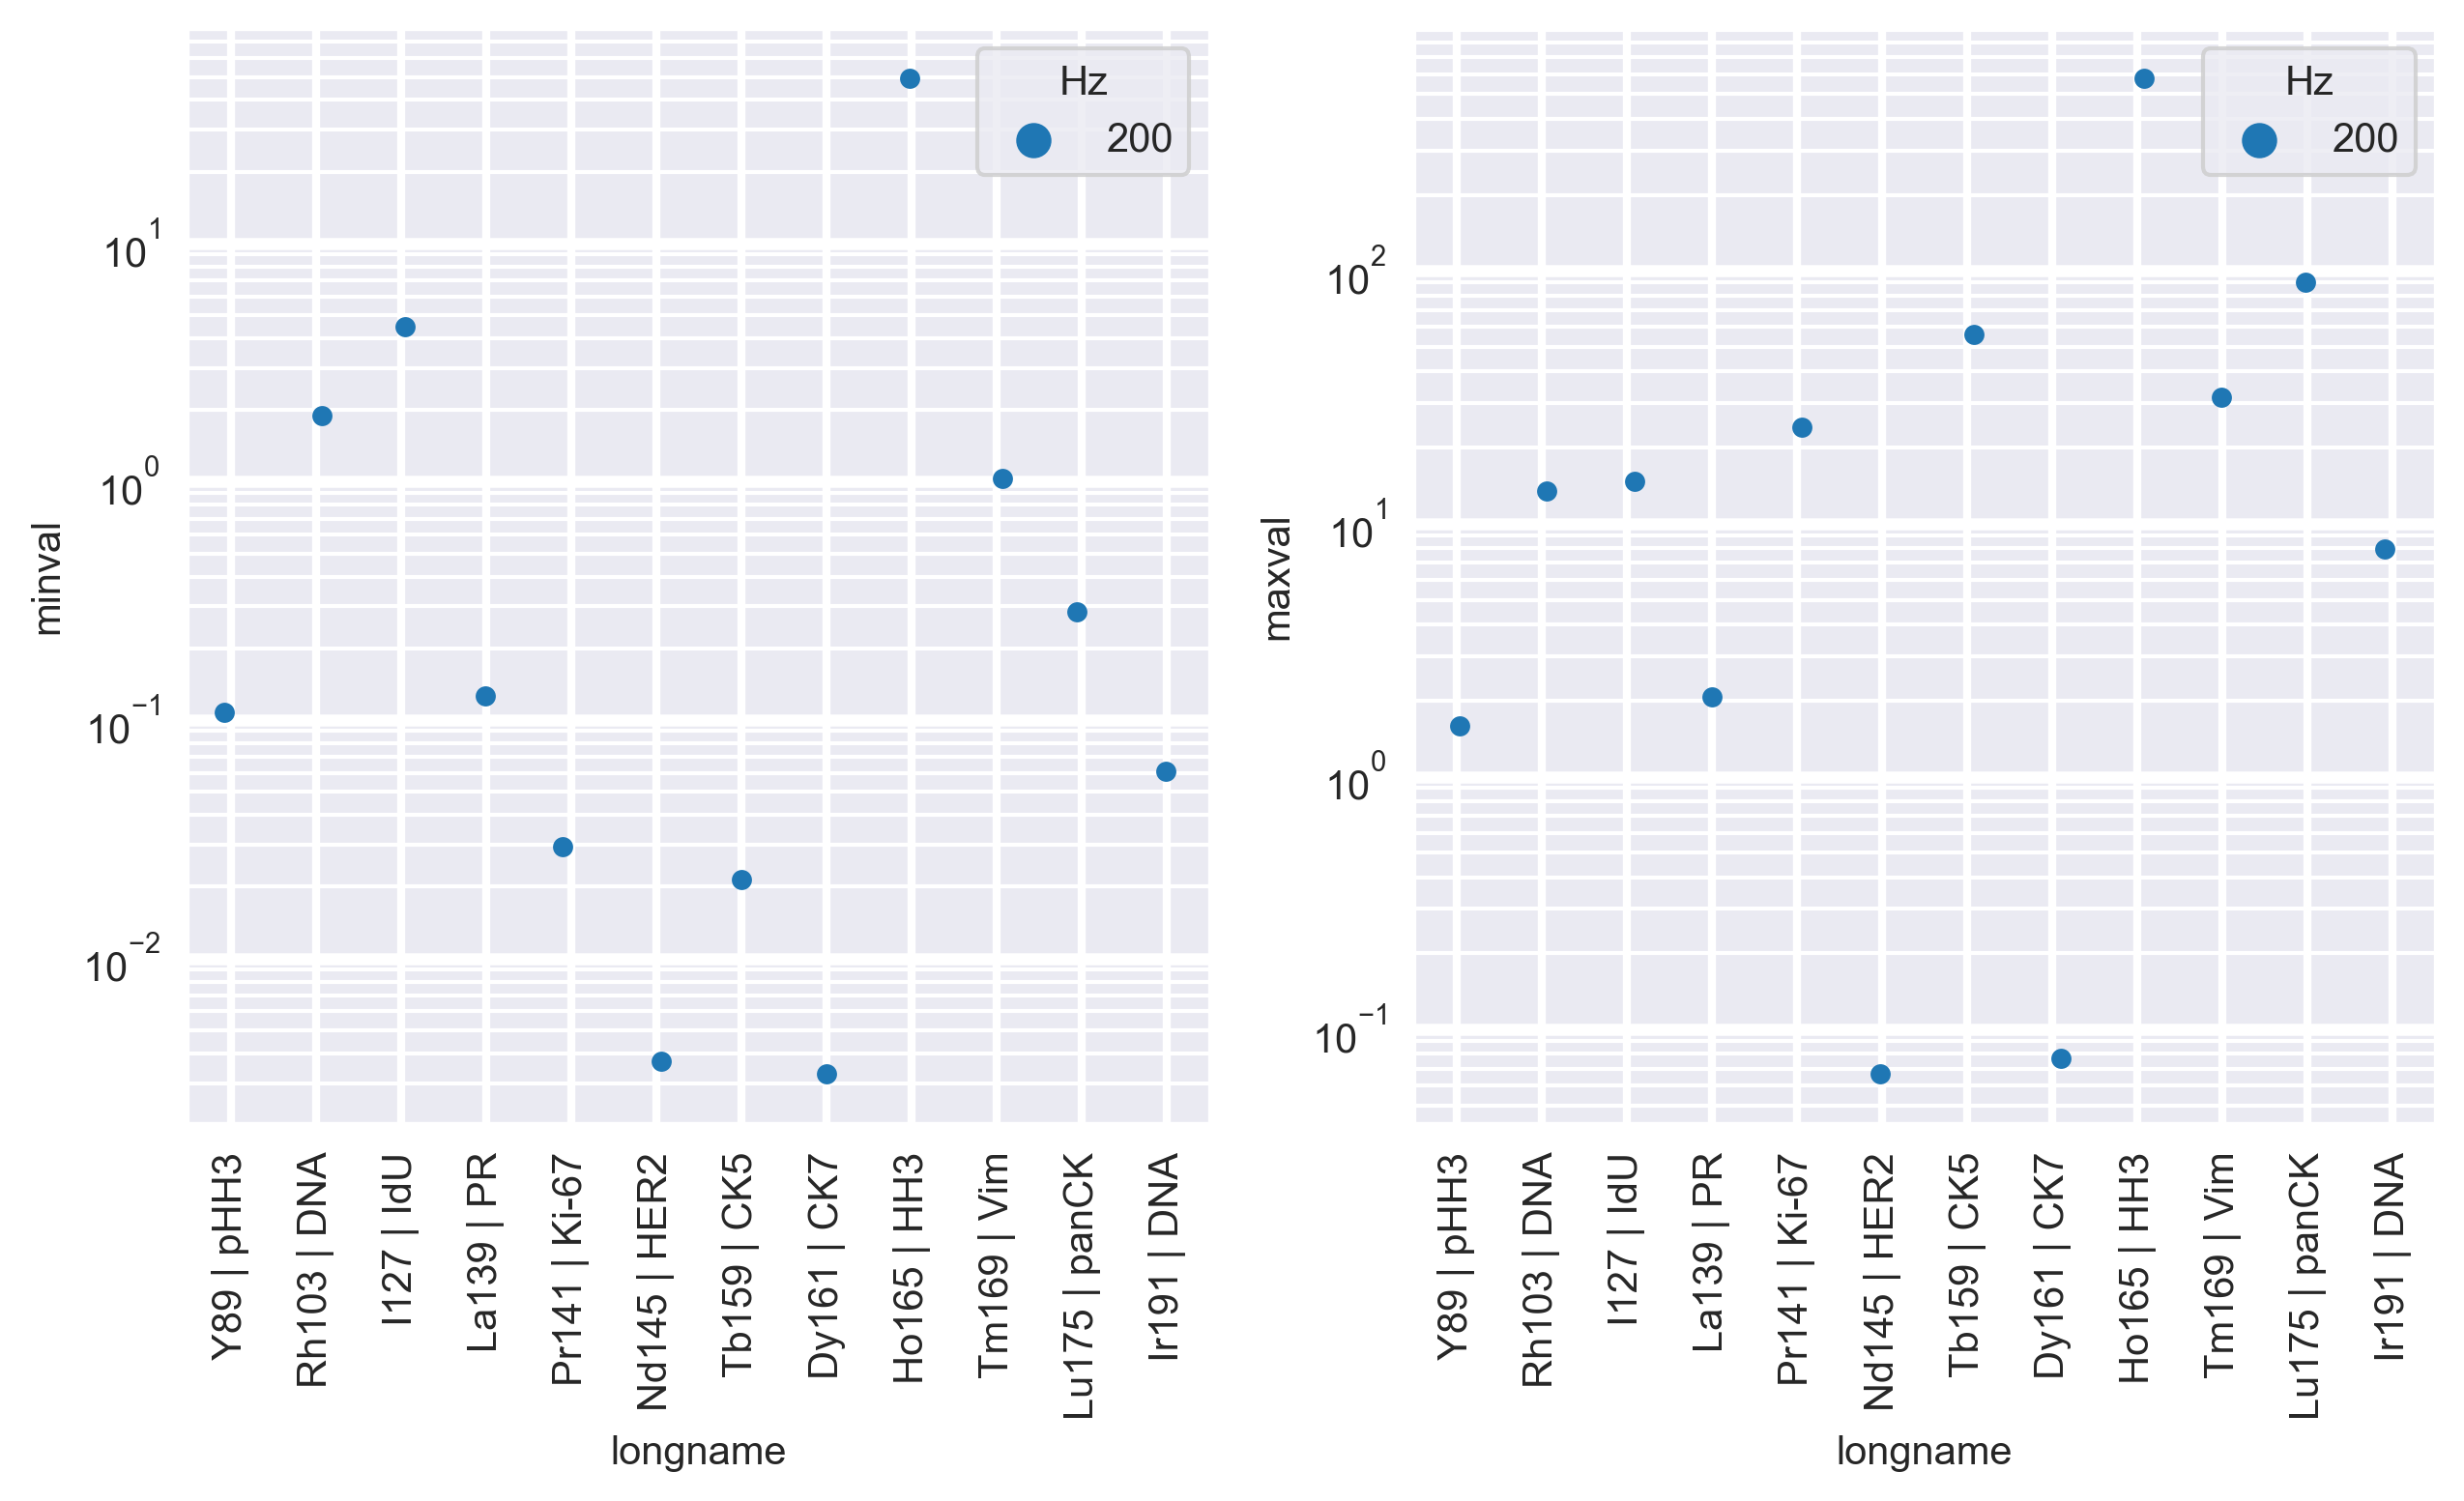

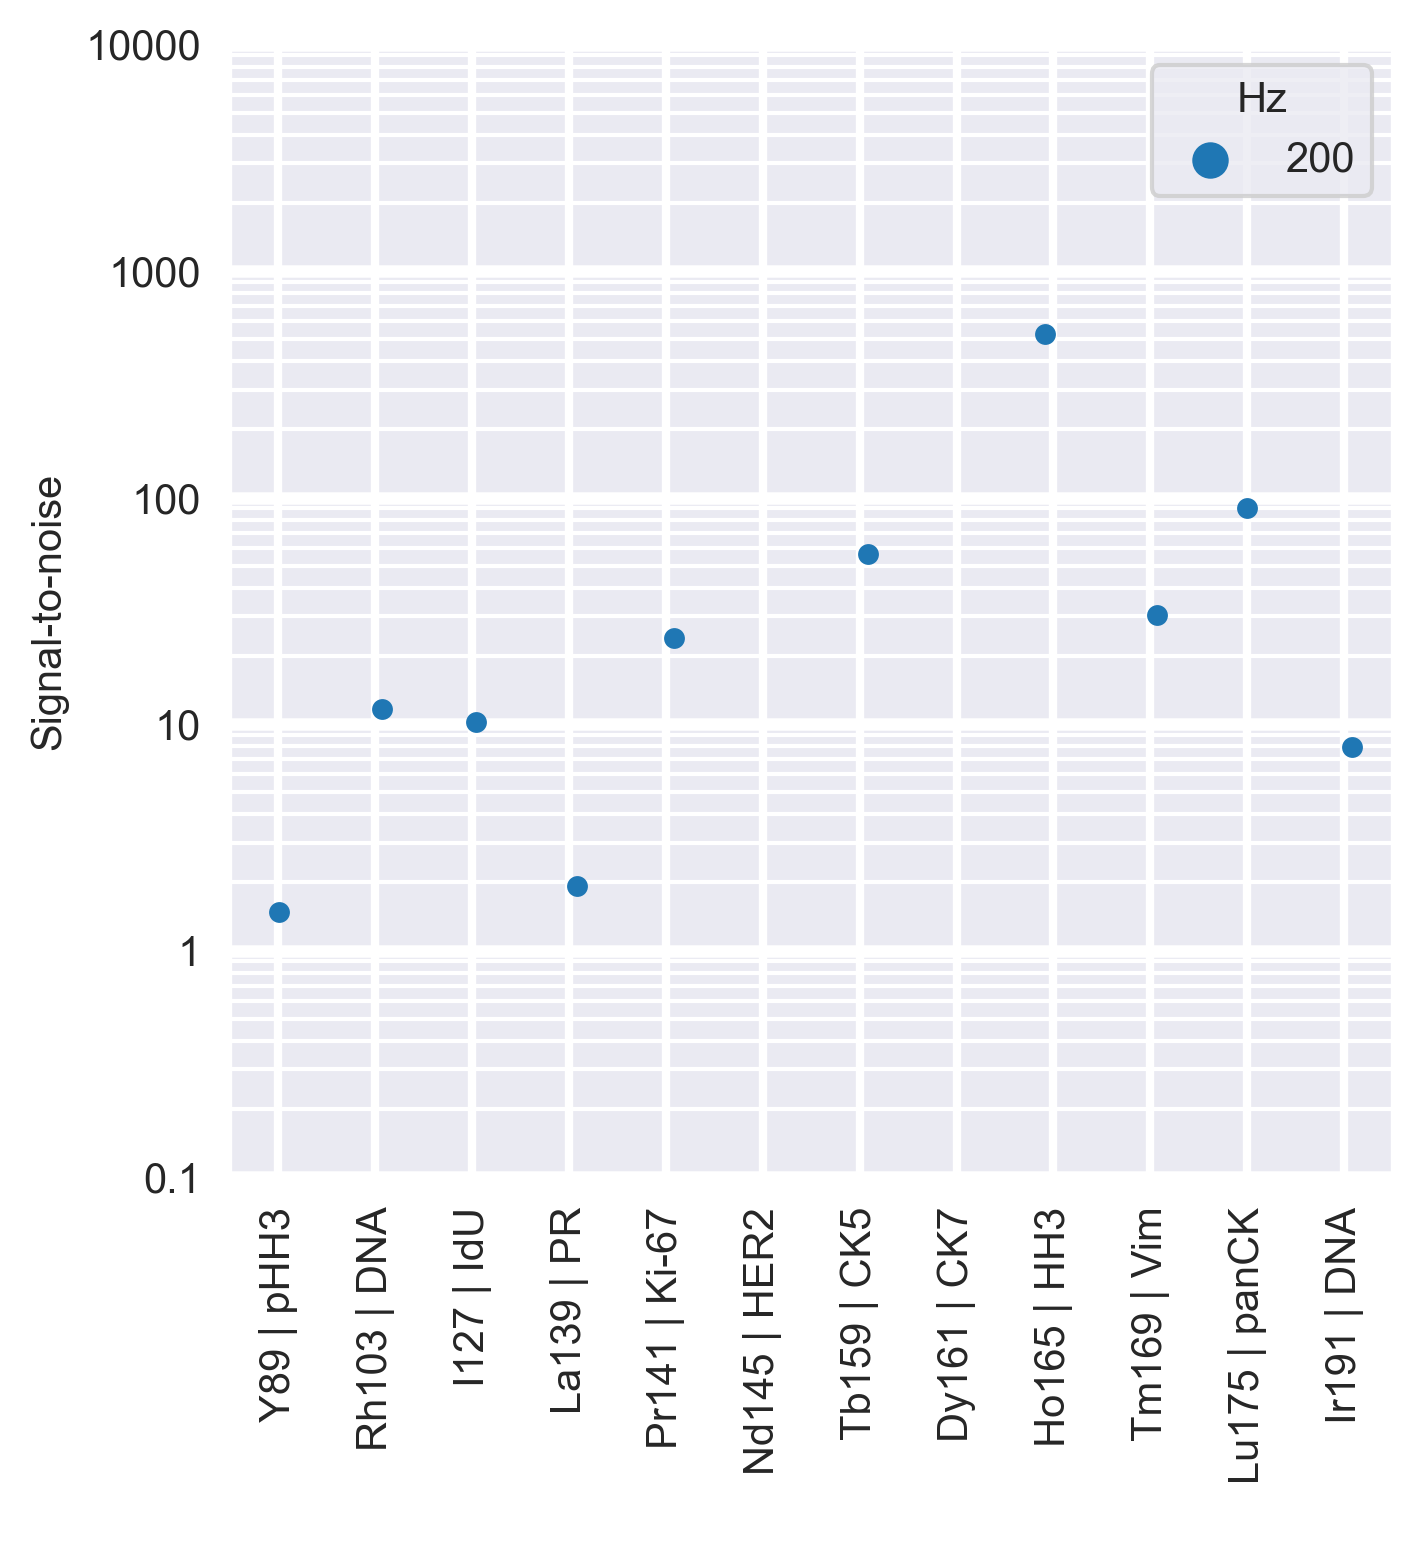

In [19]:
# Set seaborn
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

sns.set_style("dark")

### Check max and min values
fig, axs = plt.subplots(ncols = 2, figsize=(10,5), dpi=300)

g = sns.stripplot(
    data = df_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'minval',
    ax=axs[0],
    hue='Hz'
)
axs[0].tick_params(axis='x', rotation=90)

# Set scale
g.set(yscale="log")
#Set gridlines
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')

g = sns.stripplot(
    data = df_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'maxval',
    ax=axs[1],
    hue='Hz',
)
axs[1].tick_params(axis='x', rotation=90)


# Set scale
g.set(yscale="log")
#Set gridlines
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')

# Sort shared legend
# axs[0].get_legend().remove()
# axs[1].get_legend().remove()
# plt.legend(title='Raster rate (Hz)', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=90)#, ha='right')
plt.show()

### Plot signal to noise
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
g = sns.stripplot(
    data = df_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'signal-to-noise',
    ax=ax,
    hue='Hz'
)
ax.set(yscale="log")
ax.set_ylim([0.1, 10000])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')
plt.xticks(rotation=90)#, ha='right')
plt.ylabel('Signal-to-noise')
plt.xlabel(' ')
# plt.legend(title='Raster rate (Hz)', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

## IMC and XRF signal to noise of speed cell pellets

In [20]:
adata_xrf_path = pathlib.Path(r'C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF/data/processed/xrf/7b_SABER_cell_quantification/cell_pellet_speed_for_signal_to_noise_matched_cell_mask.h5ad')
adata_xrf_path.exists()

adata_xrf = ad.read_h5ad(adata_xrf_path)
adata_xrf.var


shortname                   longname
Dy_Ka    CK 7 (SABER x2)    Dy_Ka | CK 7 (SABER x2)
Gd_Ka    HER2 (SABER x2)    Gd_Ka | HER2 (SABER x2)
Ho_Ka     CK5 (SABER x2)     Ho_Ka | CK5 (SABER x2)
I_Ka                 IdU                 I_Ka | IdU
Ir_L3                DNA                Ir_L3 | DNA
La_Ka      PR (SABER x2)      La_Ka | PR (SABER x2)
Lu_Ka     Vim (SABER x2)     Lu_Ka | Vim (SABER x2)
Pr_Ka   Ki-67 (SABER x2)   Pr_Ka | Ki-67 (SABER x2)
Rh_Ka                DNA                Rh_Ka | DNA
Sm_Ka     HH3 (SABER x2)     Sm_Ka | HH3 (SABER x2)
Tb_Ka  pan CK (SABER x2)  Tb_Ka | pan CK (SABER x2)
Tm_Ka    pHH3 (SABER x2)    Tm_Ka | pHH3 (SABER x2)

In [21]:
df_xrf_signal_to_noise = pd.DataFrame()
for hz in adata_xrf.obs['Hz'].unique():
    row = {}
    row['Hz'] = hz
    adata_Hz = adata_xrf[adata_xrf.obs['Hz'] == hz]
    for var_name in adata_Hz.var_names:
        row['var_name'] = var_name

        var_values = adata_Hz[:,var_name].X

        # Sample the max and mean signal in top and bottom (specified) % of cells
        non_zero_values = sorted(var_values[np.nonzero(var_values)])
        percentage = 1
        cell_sample = int(len(non_zero_values) / 100) * percentage
        row['minval'] = np.mean(non_zero_values[:cell_sample])
        row['maxval'] = np.max(non_zero_values[-cell_sample:])

        # Add rows to dataframe
        if df_xrf_signal_to_noise.empty:
            df_xrf_signal_to_noise = pd.DataFrame(columns=row.keys())            
        df_xrf_signal_to_noise = df_xrf_signal_to_noise.append(row, ignore_index=True)
            
# # Sort data types
df_xrf_signal_to_noise['var_name'] = df_xrf_signal_to_noise['var_name'].astype('category')
df_xrf_signal_to_noise['Hz'] = df_xrf_signal_to_noise['Hz'].astype('category')
df_xrf_signal_to_noise['minval'] = df_xrf_signal_to_noise['minval'].astype('float')
df_xrf_signal_to_noise['maxval'] = df_xrf_signal_to_noise['maxval'].astype('float')
df_xrf_signal_to_noise['signal-to-noise'] = (df_xrf_signal_to_noise['maxval'] - (df_xrf_signal_to_noise['minval']))
 
df_xrf_signal_to_noise['xrf_emission'] = df_xrf_signal_to_noise['var_name'].str.split(' ', expand=True).iloc[:,0]
# df_xrf_signal_to_noise[['ab_tag', 'shortname']] = df_xrf_signal_to_noise['var_name'].str.split(' ', expand=True).iloc[:,[0,2]].rename(columns={0:'ab_tag', 1:'shortname'})
df_xrf_signal_to_noise = pd.merge(df_xrf_signal_to_noise, df_to_map, left_on='xrf_emission', right_on='xrf_emission', suffixes=('', '_y'))
df_xrf_signal_to_noise.drop(df_xrf_signal_to_noise.filter(regex='_y$').columns, axis=1, inplace=True)
df_xrf_signal_to_noise['Method'] = 'XRF (GeCMOS 2nd)'
df_xrf_signal_to_noise

C:\Users\MerrickS\Anaconda3\envs\mez-xrf\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Hz var_name     minval      maxval  signal-to-noise xrf_emission  \
0     10    Dy_Ka  83.247818  752.589966       669.342148        Dy_Ka   
1     50    Dy_Ka  16.646978  168.042831       151.395853        Dy_Ka   
2    250    Dy_Ka   2.903760   31.871246        28.967486        Dy_Ka   
3    500    Dy_Ka   1.195692   23.609011        22.413319        Dy_Ka   
4    800    Dy_Ka   0.908445   11.345567        10.437122        Dy_Ka   
..   ...      ...        ...         ...              ...          ...   
65   250    Tm_Ka   6.138427   58.592377        52.453950        Tm_Ka   
66   500    Tm_Ka   2.689979   36.484600        33.794621        Tm_Ka   
67   800    Tm_Ka   2.161254   31.571775        29.410522        Tm_Ka   
68  1000    Tm_Ka   1.683380   20.490774        18.807394        Tm_Ka   
69  1500    Tm_Ka   1.042341   15.169022        14.126680        Tm_Ka   

   shortname     longname ab_tag  tag_isotope         target ab_clone  \
0        CK7  Dy161 | CK7  Dy161          161  Cytokeratin 7   RCK105   
1        CK7  Dy161 | CK7  Dy161          161  Cytokeratin 7   RCK105   
2        CK7  Dy161 | CK7  Dy161          161  Cytokeratin 7   RCK105   
3        CK7  Dy161 | CK7  Dy161          161  Cytokeratin 7   RCK105   
4        CK7  Dy161 | CK7  Dy161          161  Cytokeratin 7   RCK105   
..       ...          ...    ...          ...            ...      ...   
65       Vim  Tm169 | Vim  Tm169          169       Vimentin  EPR3776   
66       Vim  Tm169 | Vim  Tm169          169       Vimentin  EPR3776   
67       Vim  Tm169 | Vim  Tm169          169       Vimentin  EPR3776   
68       Vim  Tm169 | Vim  Tm169          169       Vimentin  EPR3776   
69       Vim  Tm169 | Vim  Tm169          169       Vimentin  EPR3776   

    stock_conc_ug_per_ml  use_conc_ug_per_mL  nuclear_segment  cell_segment  \
0                    NaN                 NaN              NaN           NaN   
1                    NaN                 NaN              NaN           NaN   
2                    NaN                 NaN              NaN           NaN   
3                    NaN                 NaN              NaN           NaN   
4                    NaN                 NaN              NaN           NaN   
..                   ...                 ...              ...           ...   
65                   NaN                 NaN              NaN           1.0   
66                   NaN                 NaN              NaN           1.0   
67                   NaN                 NaN              NaN           1.0   
68                   NaN                 NaN              NaN           1.0   
69                   NaN                 NaN              NaN           1.0   

   Symbol  AtomicNumber     Element            Method  
0      Dy            66  Dysprosium  XRF (GeCMOS 2nd)  
1      Dy            66  Dysprosium  XRF (GeCMOS 2nd)  
2      Dy            66  Dysprosium  XRF (GeCMOS 2nd)  
3      Dy            66  Dysprosium  XRF (GeCMOS 2nd)  
4      Dy            66  Dysprosium  XRF (GeCMOS 2nd)  
..    ...           ...         ...               ...  
65     Tm            69     Thulium  XRF (GeCMOS 2nd)  
66     Tm            69     Thulium  XRF (GeCMOS 2nd)  
67     Tm            69     Thulium  XRF (GeCMOS 2nd)  
68     Tm            69     Thulium  XRF (GeCMOS 2nd)  
69     Tm            69     Thulium  XRF (GeCMOS 2nd)  

[70 rows x 20 columns]

In [22]:
df_collated_signal_to_noise = df_signal_to_noise[['Hz', 'minval', 'maxval', 'signal-to-noise', 'ab_tag', 'Symbol', 'longname', 'AtomicNumber', 'Element', 'Method']]
df_collated_signal_to_noise = df_collated_signal_to_noise.append(df_xrf_signal_to_noise[df_collated_signal_to_noise.columns], ignore_index=True)
df_collated_signal_to_noise['Hz'] = df_collated_signal_to_noise['Hz'].astype('int')
# df_collated_signal_to_noise = df_collated_signal_to_noise[df_collated_signal_to_noise['Symbol'] != 'Ir']

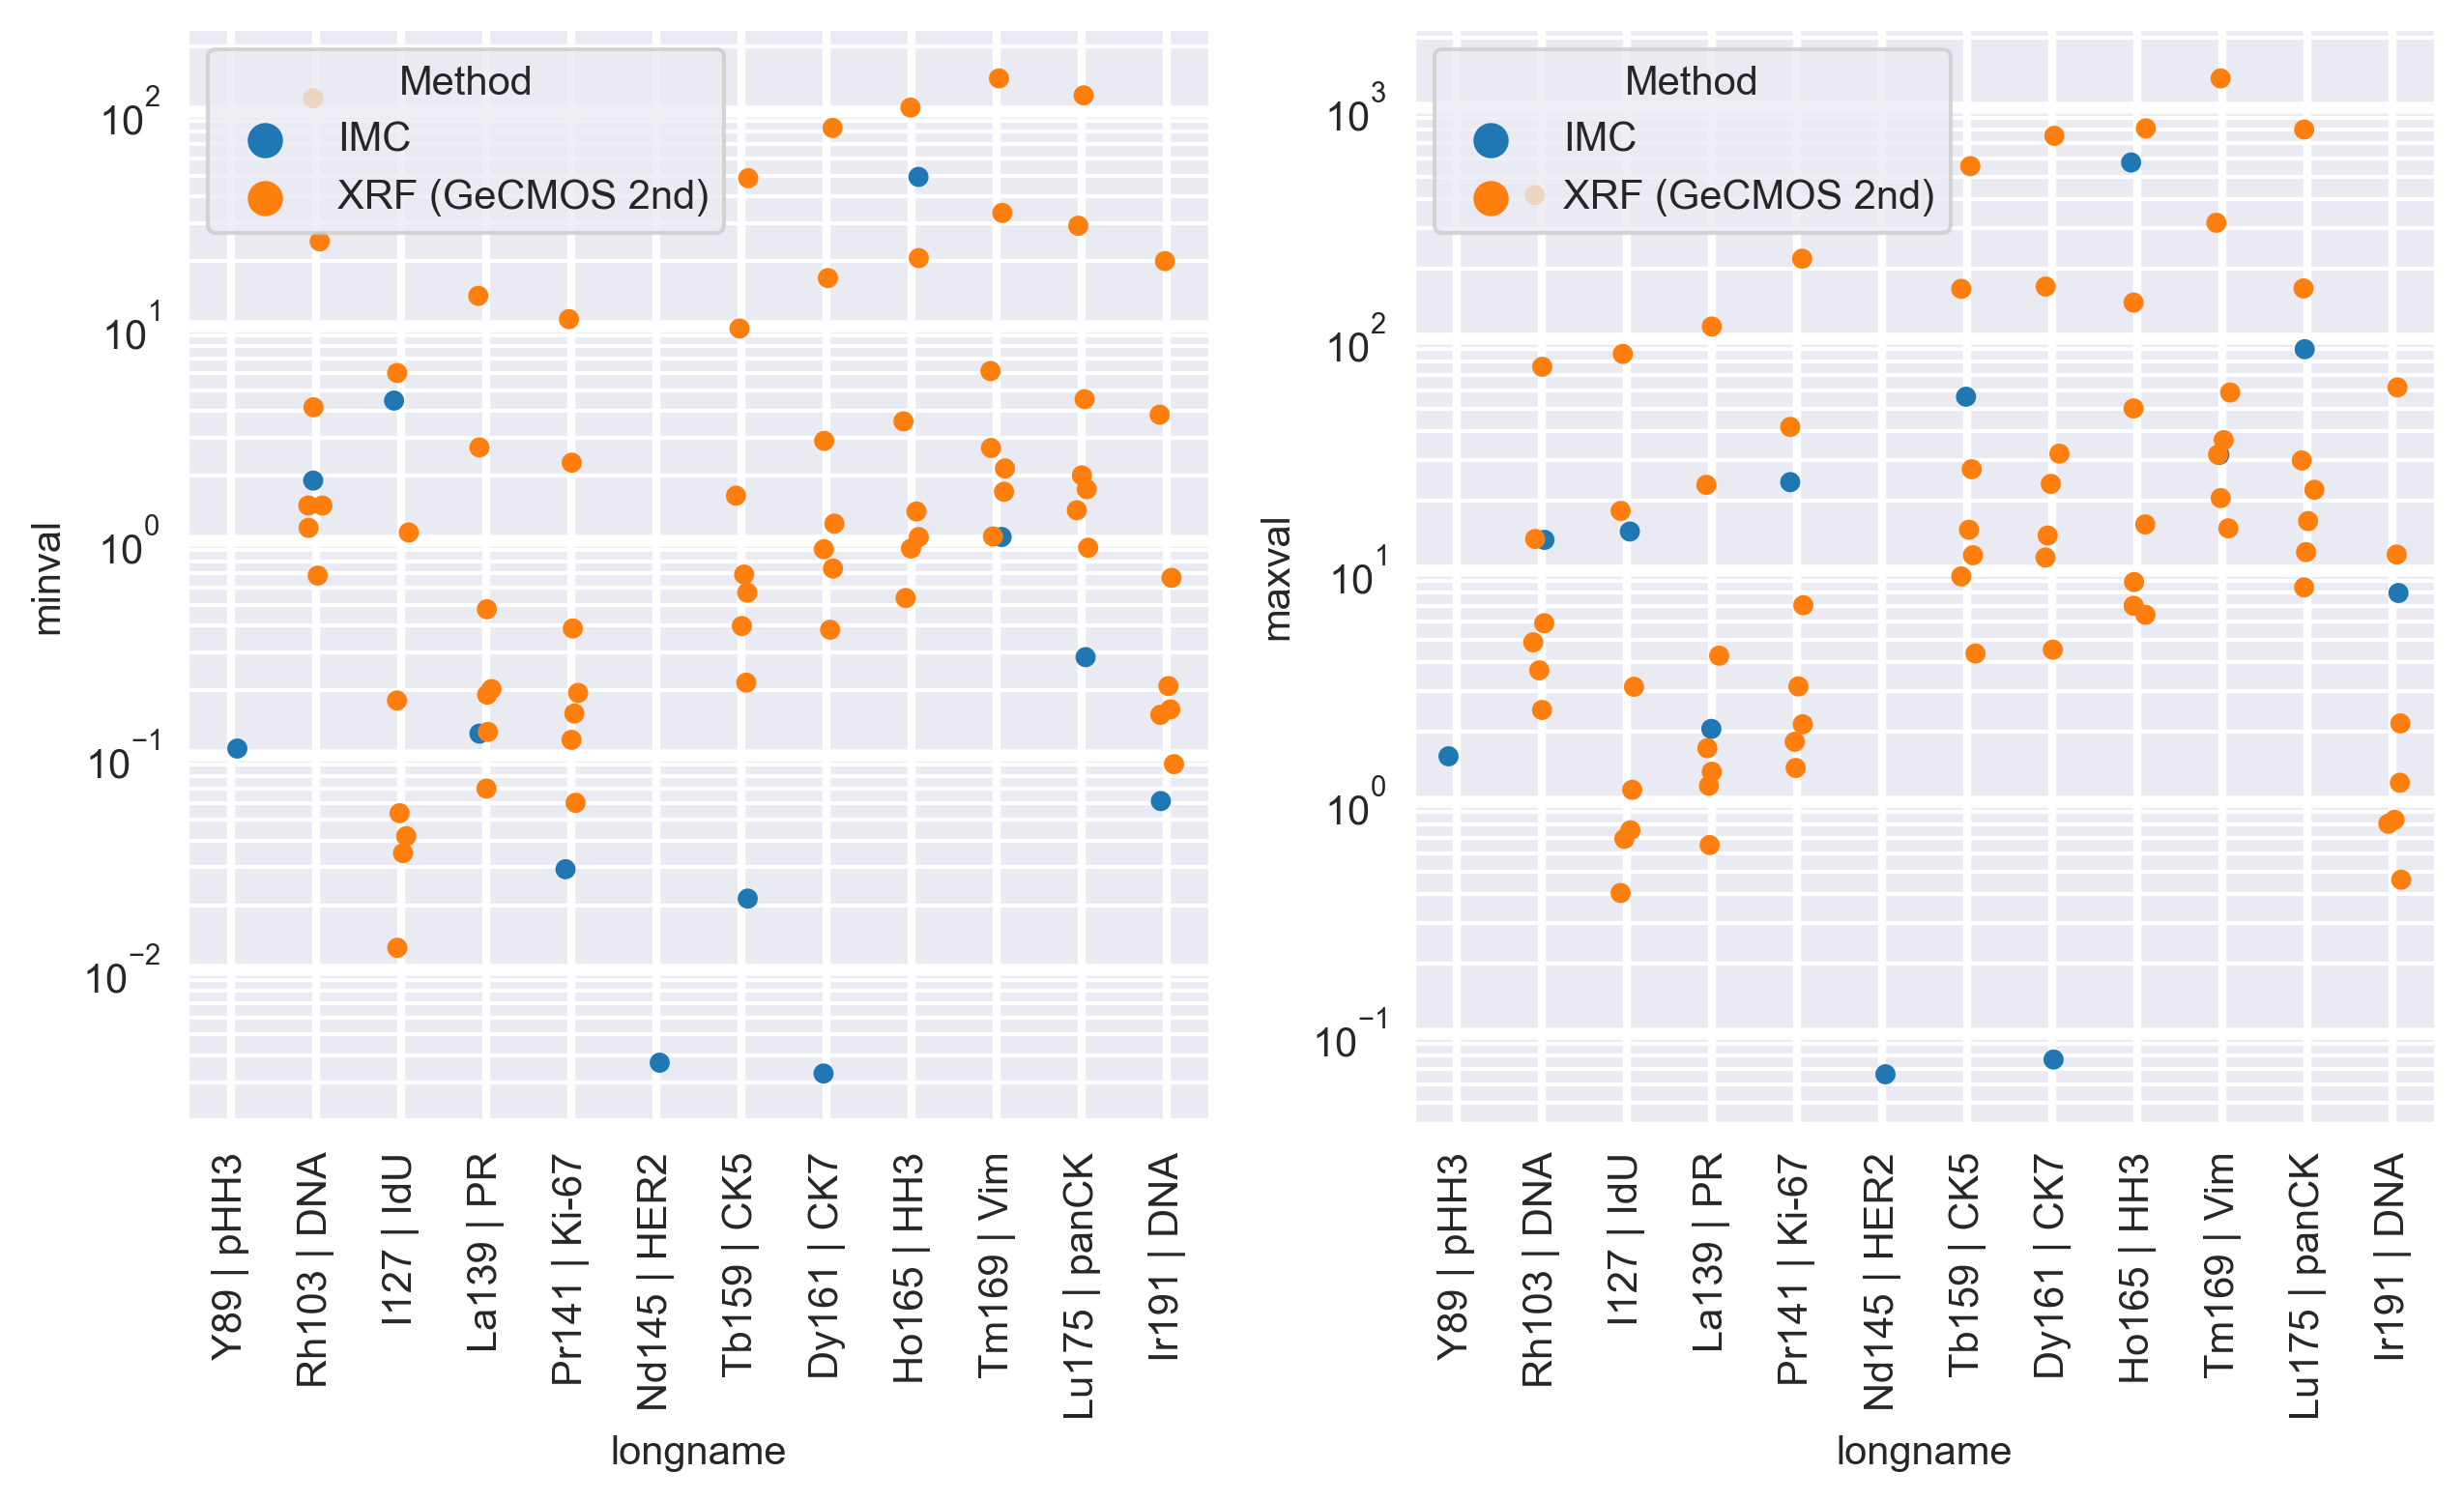

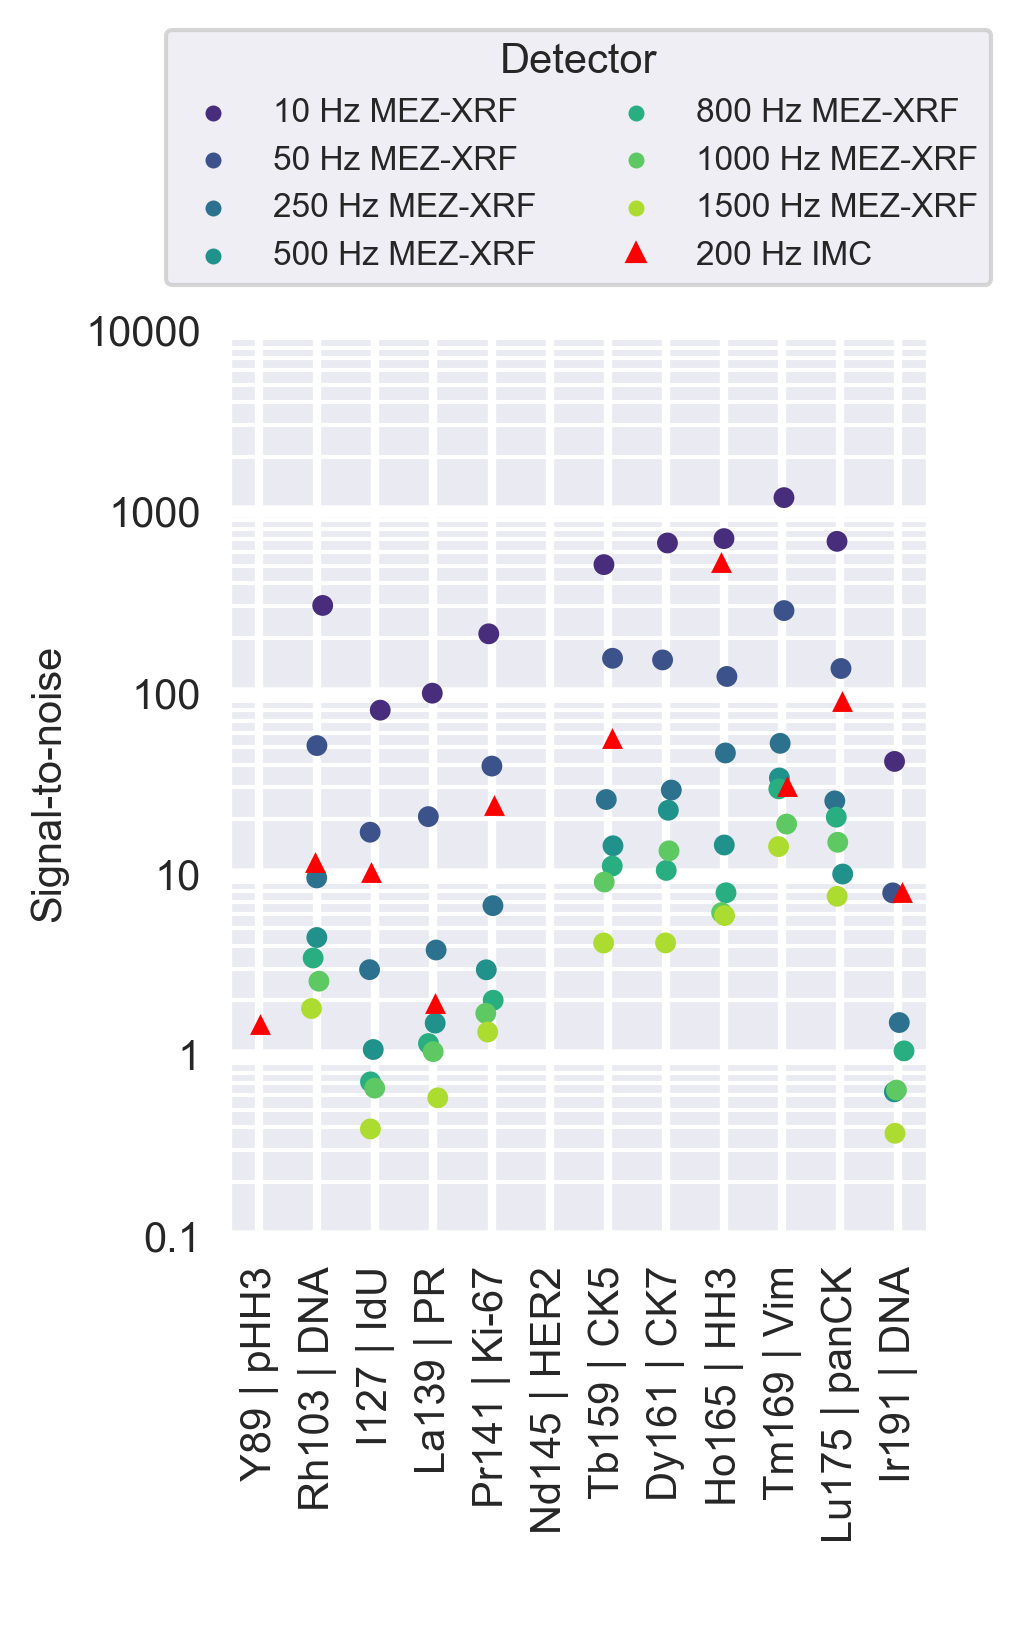

In [25]:
# Set seaborn
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

sns.set_style("dark")

### Check max and min values
fig, axs = plt.subplots(ncols = 2, figsize=(10,5), dpi=300)

g = sns.stripplot(
    data = df_collated_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'minval',
    ax=axs[0],
    hue='Method'
)
axs[0].tick_params(axis='x', rotation=90)

# Set scale
g.set(yscale="log")
#Set gridlines
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')

g = sns.stripplot(
    data = df_collated_signal_to_noise,
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'maxval',
    ax=axs[1],
    hue='Method'
)
axs[1].tick_params(axis='x', rotation=90)

# Set scale
g.set(yscale="log")
#Set gridlines
g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')

plt.xticks(rotation=90)#, ha='right')
plt.show()

### Plot signal to noise
fig, ax = plt.subplots(figsize=(3,4), dpi=300)
g = sns.stripplot(
    data = df_collated_signal_to_noise[df_collated_signal_to_noise['Method'] == 'XRF (GeCMOS 2nd)'],
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'signal-to-noise',
    ax=ax,
    hue='Hz',    
    palette = 'viridis'
)

g = sns.stripplot(
    data = df_collated_signal_to_noise[df_collated_signal_to_noise['Method'] == 'IMC'],
    x = 'longname',
    order = df_to_map.sort_values('AtomicNumber')['longname'].to_list(),
    y = 'signal-to-noise',
    ax=ax,
    hue='Method',  
    palette = ['red'],
    marker='^',
)

ax.set(yscale="log")
ax.set_ylim([0.1, 10000])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

# Custom set the marker for IMC
handles, labels = ax.get_legend_handles_labels()
red_triangle = mlines.Line2D([], [], color='red', marker='^', linestyle='None', markersize=4, label='Purple triangles')
handles[-1] = red_triangle

lgd = plt.legend(
    title='Detector',
    loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2,
    borderaxespad=0., 
    labels=['10 Hz MEZ-XRF', '50 Hz MEZ-XRF', '250 Hz MEZ-XRF', '500 Hz MEZ-XRF', '800 Hz MEZ-XRF', '1000 Hz MEZ-XRF', '1500 Hz MEZ-XRF', '200 Hz IMC'],
    handles = handles,
    fontsize=8
)

for legend_handle in lgd.legendHandles[:-1]:
    legend_handle.set_sizes([8])

g.grid(which='major', c='w', lw=3, axis='y')
g.grid(which='major', c='w', lw=2, axis='x')
g.grid(which='minor', c='w', lw=1, axis='y')
g.grid(which='minor', c='w', lw=1, axis='x')
plt.xticks(rotation=90)#, ha='right')
plt.ylabel('Signal-to-noise')
plt.xlabel(' ')

plt.show()